<div class="alert alert-block alert-danger">
note for a better experience</div>

# Projet Fil <span style='color:red'> Rouge  </span> 2023 : Reconnaissance de commandes audio

**Last name :** Besbes & Rool

**First Name :** Inès & Sara

**Name of the pair :** Besbouilla

**Summary :**
- I) Preprocessing
- II) Multiclass regression
- III) Classification by kernel methods
- IV)
- V)

# I) Preprocessing

## A) Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math
import numpy.random as rnd
import seaborn as sns
import librosa
from os import listdir
from os.path import isfile, join
import glob
import re
from scipy import signal
from scipy.fft import fft
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## B) Data import + trim

<div class="alert alert-block alert-info">
From moodle, we import a file of audio recordings of command words for a quadcopter drone made up of several male speakers (denoted M01..M13) and female speakers (F01..F05) for a few commands.</div>

In [2]:
data = [] 
label = [] 
genres = []
min_duration = None
words = ['avance','recule','tournegauche']
list_genres = ['M', 'F']

for file_name in glob.glob('FichierTest/*.wav'):
    record = librosa.load(file_name)[0]
    data.append(record)
    # Computation of the minimal size of recordings
    if min_duration is None or record.shape[0] < min_duration:
        min_duration = record.shape[0] 
    
    # Creation of the vector of label
    for i, word in enumerate(words):
      if re.search(word, file_name):
        label.append(i)

    # Creation of the vector of label
    for i, genre in enumerate(list_genres):
      if re.search(genre, file_name[12:]):# 12 is for ignoring "FichierTest/"
        genres.append(genre)

fs = librosa.load(file_name)[1] # Sampling frequency
genres = np.array(genres)
print(f'The smallest record contains {min_duration} samples, and the sample frequency is {fs} Hz')


The smallest record contains 18522 samples, and the sample frequency is 22050 Hz


<div class="alert alert-block alert-info">
We trim the recordings to isolate the word and have identical durations.
</div>

In [3]:
def trim(record):
    half_duration = 18522//2

    # First, we compute the barycenter of energy along time. We interpret it as the moment when the word appears
    barycenter = int(np.floor(np.multiply(np.power(record,2),np.arange(0,record.shape[0],1)).sum()/np.power(record,2).sum()))

    # Second, we adjust the barycenter to be in the index range
    if barycenter-half_duration < 0:
        barycenter += half_duration-barycenter
    if barycenter+half_duration >= record.shape[0]:
        barycenter -= barycenter+half_duration - record.shape[0]
    
    # Finally, we trim the recording around the barycenter 
    return record[barycenter-half_duration:barycenter+half_duration]

In [4]:
X = np.empty((len(data),min_duration))
for i in range(len(data)):
    X[i,:] = trim(data[i])

y = np.array(label)
print(f'Shape of inputs X is{X.shape} and size of targets class is {y.shape}')

Shape of inputs X is(54, 18522) and size of targets class is (54,)


## C) Dimension reduction

<div class="alert alert-block alert-info">
We use spectral representation to reduce the dimension of our data. Indeed, we have at the beginning 54 signals of 18522 data each. It is important to reduce the dimension before applying classifiers to facilitate their performance and results.

For this, we implement 2 methods: FFT + PCA & STFT.
</div>

### 1) FFT + PCA

In [5]:
X_fft = fft(X)
pca = PCA()
pca.fit(np.absolute(X_fft.T)) #we take the module of X_fft
# print(np.shape(X_fft))

PCA()

In [6]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(54)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
).rename(columns = {'% cum. var. expliquée' : '% cumulative variance'})
# eig

<div class="alert alert-block alert-info">
With the graph below, we decide to keep 15 components.
</div>

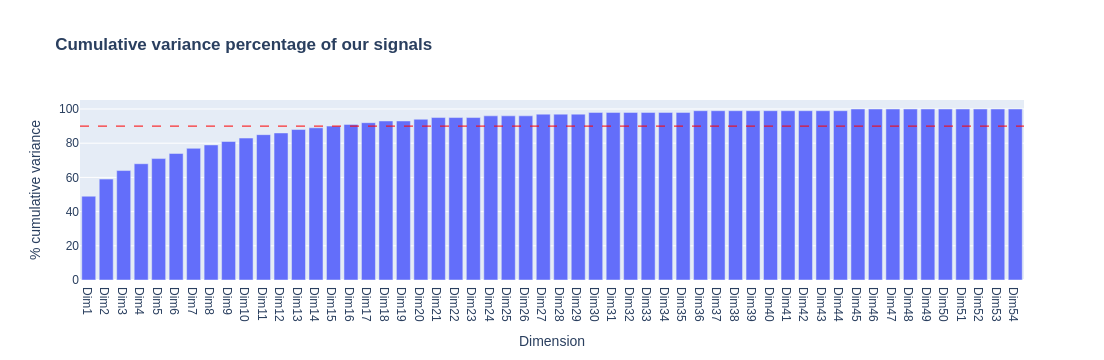

In [34]:
fig = px.bar(eig, x="Dimension", y="% cumulative variance", title='<b>Cumulative variance percentage of our signals</b>')
fig.add_hline(y=90, line_width=1, line_dash="dash", line_color="red")
fig.show()

### 2) STFT

In [8]:
nperseg = 253
f, t, X_stft = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
X_stft.shape

(127, 168)

<div class="alert alert-block alert-info">
The dimension of X after the STFT and without cutting frequencies is (127, 168).

We notice that we can cut the frequencies at 80 because there is no information beyond.
</div>

(127, 147)


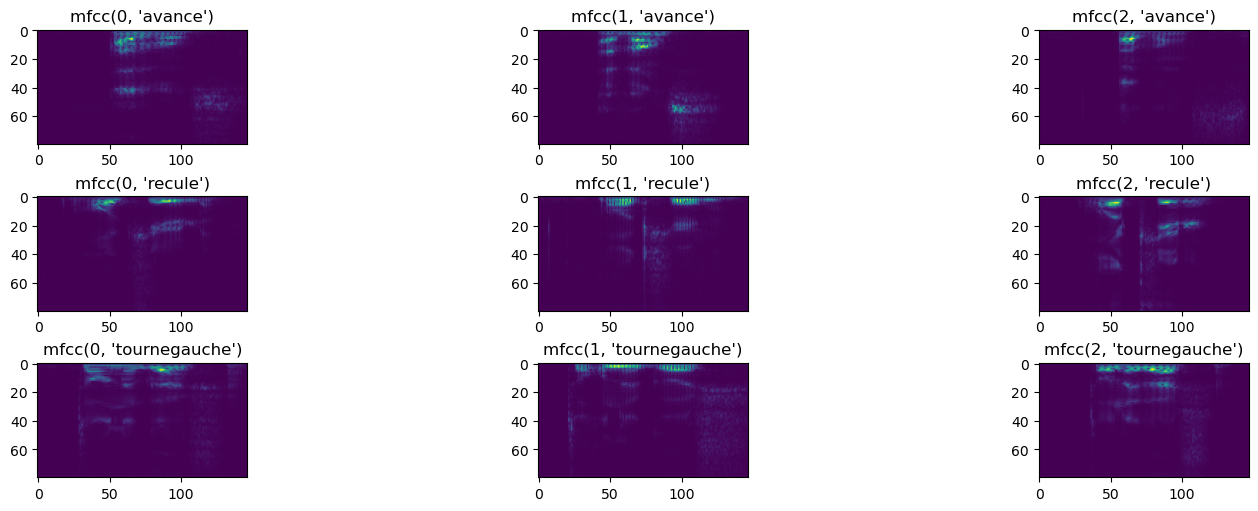

In [9]:
nperseg = 253

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'M')][instance]
        f, t, Zxxm = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxxm[:80])) # we cut the frequencies here
        axs[i,instance].set_title(f'mfcc{instance,word}')

        
print(Zxxm.shape)
plt.show()

(127, 147)


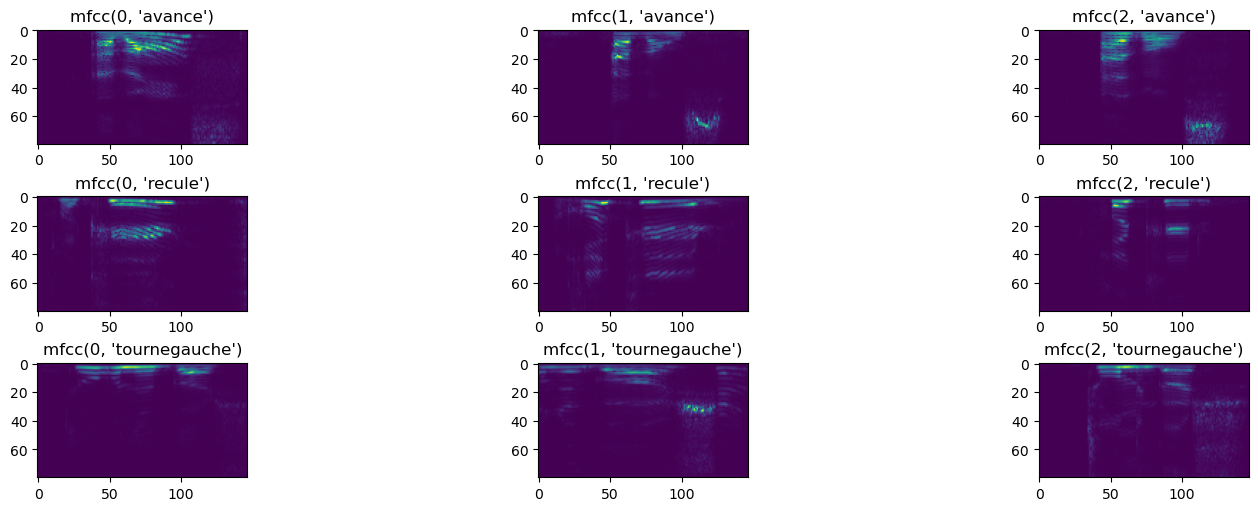

In [10]:
nperseg = 253

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'F')][instance]
        f, t, Zxxf = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxxf[:80])) # we cut the frequencies here
        axs[i,instance].set_title(f'mfcc{instance,word}')

        
print(Zxxf.shape)
plt.show()

### 3) Class construction


<div class="alert alert-block alert-info">
We define 2 classes: FFT and STFT. We need this to be able to use transform functions in our pipelines that are not defined in the base functions.
</div>

In [11]:
class FFT(BaseEstimator, TransformerMixin):
    def __init__(self, idx_frequence_max=None):
        self.idx_frequence_max = idx_frequence_max
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return np.absolute(fft(X)[:self.idx_frequence_max])

In [12]:
class STFT():
    def __init__(self, idx_frequence_max = None, stat = None):
        self.idx_frequence_max = idx_frequence_max    
        self.stat = stat
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        nperseg = 253
        f, t, Zxxm = signal.stft(X, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        Zxxm_trans = np.absolute(Zxxm[:, :self.idx_frequence_max, :])
        X_trans = np.zeros((Zxxm_trans.shape[0],Zxxm_trans.shape[1]))
        for s in range(Zxxm_trans.shape[0]):
            for i in range(Zxxm_trans.shape[1]):
                X_trans[s, i] = self.stat(Zxxm_trans[s,i,:])
        return X_trans

    #usefull to use pipeline
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# II) Multiclass regression

<div class="alert alert-block alert-info">
In this part, we consider a logistic regression model.</div>


We model the probabilities by the following form :

$$
\mathbb{P}(Y_i = j) = \frac { \exp^{-\beta_j^{T} X_i } } {1 + \sum_{\ell = 1}^{K-1} \exp^{-\beta_\ell^{T} X_i }}, 
$$
For all $j$ in $\{ 1,2, \dots , K-1 \}$.


## A) Cross validation from scratch

<div class="alert alert-block alert-info">
To better understand cross validation, we implement the function ourselves. We will then use the already existing functions. We also decided to implement other functions to simplify the display.</div>

### 1) Plot function

<div class="alert alert-block alert-info">
    
- This <b>CrossValidation</b> function takes as input the X, y and the coefficient C for the logistic regression. Then returns the mean_accuracy, a y_test and its associated y_pred_test.
- The <b>C_variation</b> function applies our cross validation for several values ​​of C.
- The <b>accuracy_plot</b> function plot the accuracy for the train & test set and the max accuracy.
- The <b>confusion_matrix_visu</b> is a personnalized confusion matrix function.
</div>

In [20]:
def CrossValidation(X, y, C, n = 3):
    #shuffle indexs
    idx = np.arange(X.shape[0])
    idx = shuffle(idx)
    Xs = X[idx]
    ys = y[idx]

    #we divide into 3 sets
    n_folds = n
    l = Xs.shape[0]
    X_test = []
    X_train = []
    y_test = []
    y_train = []
    for i in range(n_folds):
        idx_test = idx[round(l*i/n_folds):round(l*(i+1)/n_folds)]
        idx_train = idx.tolist()
        for j in idx_test:
            idx_train.remove(j)
        X_test.append(Xs[idx_test, :])
        X_train.append(Xs[idx_train, :])
        y_test.append(ys[idx_test])
        y_train.append(ys[idx_train])

    #model instanciation
    model = LogisticRegression(C = C, max_iter = 1000)

    #computing the score
    score_test = []
    score_train = []
    for i in range(n_folds):
        model.fit(X_train[i], y_train[i])
        y_pred_train = model.predict(X_train[i])
        y_pred_test = model.predict(X_test[i])
        fold_score_test = accuracy_score(y_test[i], y_pred_test)
        score_test.append(fold_score_test)
        fold_score_train = accuracy_score(y_train[i], y_pred_train)
        score_train.append(fold_score_train)
    mean_accuracy_test = np.mean(score_test)
    mean_accuracy_train = np.mean(score_train)
    return mean_accuracy_test, mean_accuracy_train, y_test, y_pred_test

In [21]:
def C_variation(X, y, start, stop, step):
    tab_accuracy_test = []
    tab_accuracy_train = []
    tab_y_test = []
    tab_y_pred_test = []
    x_axis = []
    for C in np.arange(start, stop, step):
        x_axis.append(C)
        accuracy_test, accuracy_train, y_test, y_test_pred = CrossValidation(X, y, C)
        tab_accuracy_test.append(accuracy_test)
        tab_accuracy_train.append(accuracy_train)
        tab_y_test.append(y_test[2])
        tab_y_pred_test.append(y_test_pred)
        
    tab =  pd.DataFrame(
    {
        "C" : x_axis, 
        "Accuracy_test" : tab_accuracy_test,
        "Accuracy_train" : tab_accuracy_train,
        "Y_test" : tab_y_test,
        "Y_pred" : tab_y_pred_test,
        "Accuracy_test_max" : np.max(tab_accuracy_test),

    }
    )
    return tab

In [22]:
def accuracy_plot(df):
    fig = px.line(df, x="C", y=['Accuracy_test', 'Accuracy_train', 'Accuracy_test_max'], title='<b>Accuracy results in function of C </b>')
    fig.add_hline(y=df.Accuracy_test.max(), line_width=1, line_dash="dash", line_color="green")
    fig.update_layout(yaxis_range=[0,1.1], yaxis_title = 'Score')
    fig.show()
    print("The best test score is : "+str(df.Accuracy_test.max()))

In [35]:
def confusion_matrix_visu(df):
    cm = confusion_matrix(df.Y_test[df.Accuracy_test.idxmax()],df.Y_pred[df.Accuracy_test.idxmax()], normalize = 'true')
    z = np.round(cm, 2)
    
    x = ['Avance', 'Recule', 'Tournegauche']
    y =  ['Avance', 'Recule', 'Tournegauche']
    
    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]
    
    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text)
    
    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                     )
    
    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Predicted value",
                            xref="paper",
                            yref="paper"))
    
    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=100))
    
    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.1,
                            y=0.5,
                            showarrow=False,
                            text="Real value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))
    # put the x_axis annotation on the bottom
    fig.update_layout(
        xaxis=dict(side='bottom')
    )
    
    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.show()

### 2) Results on initial data

<div class="alert alert-block alert-info">
We apply the algorithm directly to the data without transformations. We then see overfitting which gives poor results on the prediction of the test data but very good results on the training data (hence the overfitting).
</div>

In [241]:
initial_data_plot = C_variation(X, y, 0.1, 1, 0.1)

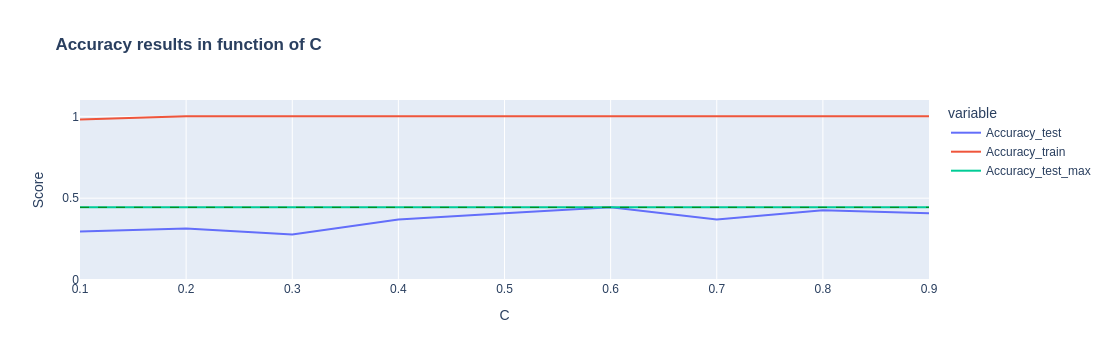

The best test score is : 0.4444444444444444


In [243]:
accuracy_plot(initial_data_plot)

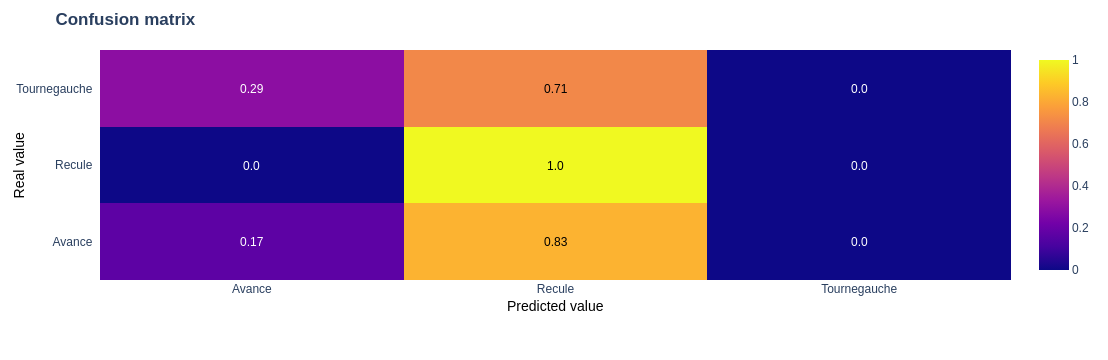

In [262]:
confusion_matrix_perso(initial_data_plot)

<div class="alert alert-block alert-info">
We notice thanks to the confusion matrix above that our data is very poorly classified. We must therefore necessarily modify our data.
</div>

### 3) Results on FFT + PCA data

<div class="alert alert-block alert-info">
We apply the model to our data transformed by FFT + PCA. We kept 15 dimensions for the PCA.
</div>

In [268]:
pca = PCA(n_components=15)
X_pca = pca.fit(np.absolute(X_fft.T)).components_.T

In [287]:
pca_data_plot = C_variation(X_pca, y, 10, 100, 5)

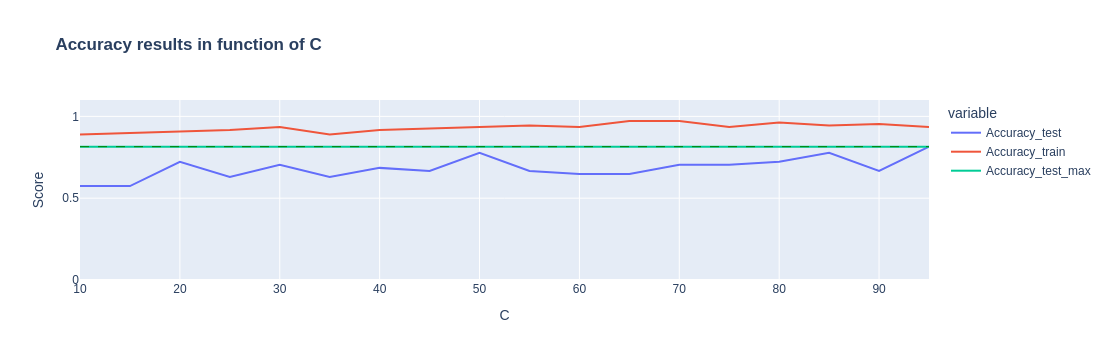

The best test score is : 0.8148148148148148


In [288]:
accuracy_plot(pca_data_plot)

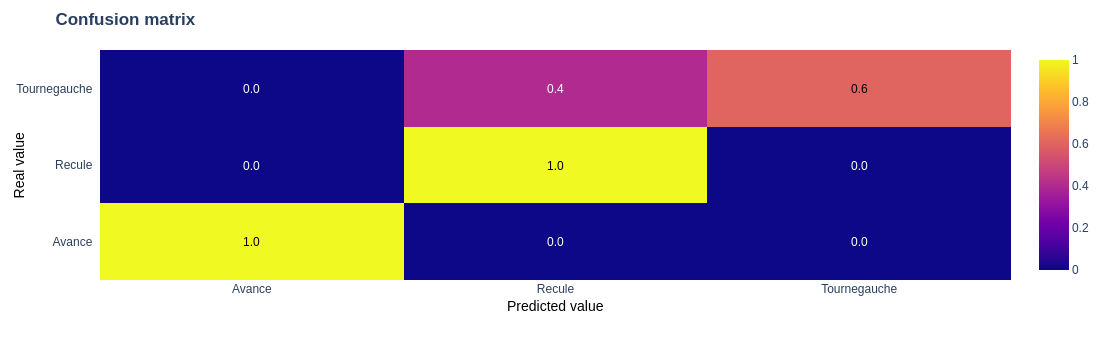

In [289]:
confusion_matrix_perso(pca_data_plot)

<div class="alert alert-block alert-info">
We see that our data is much better classified. In fact, we classified correctly 70% of the time. We also notice that we no longer have any overfitting.</div>

### 4) Results on STFT data

<div class="alert alert-block alert-info">
Analogously, we do the same thing as before but on our data modified by STFT.</div>

In [303]:
stft = STFT(idx_frequence_max = 90, stat = np.mean)
X_stft = stft.transform(X)

In [304]:
stft_data_plot = C_variation(X_stft, y, 1000, 5000, 200)

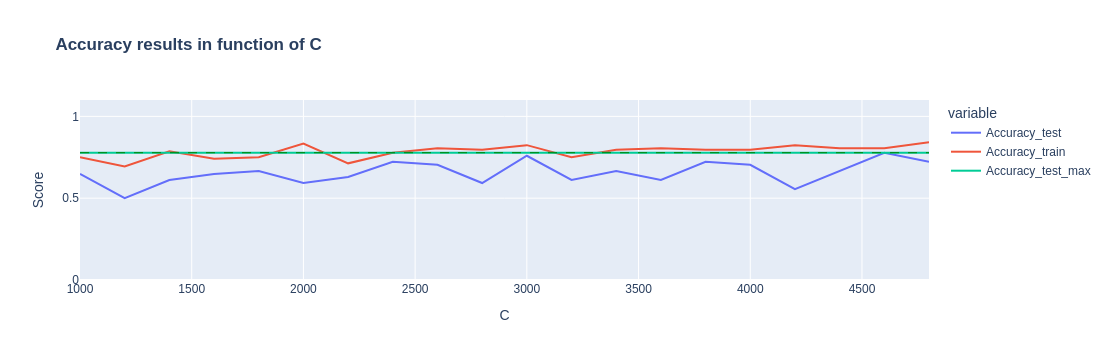

The best test score is : 0.7777777777777778


In [292]:
accuracy_plot(stft_data_plot)

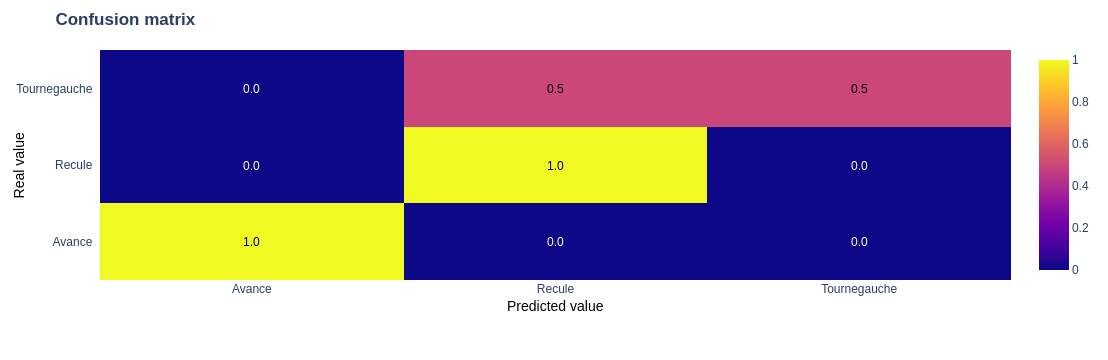

In [293]:
confusion_matrix_perso(stft_data_plot)

<div class="alert alert-block alert-info">
Similar results are obtained when using FFT + PCA. These predictions are satisfactory. There's no overfitting. </div>

### 5) Results on STFT + Scaling

<div class="alert alert-block alert-info">
This time, we scale our data after applying the stft.</div>

In [295]:
scaler = StandardScaler()

In [301]:
X_stft_scale = scaler.fit_transform(stft.transform(X))

In [305]:
stft_scale_data_plot = C_variation(X_stft_scale, y, 1000, 5000, 200)

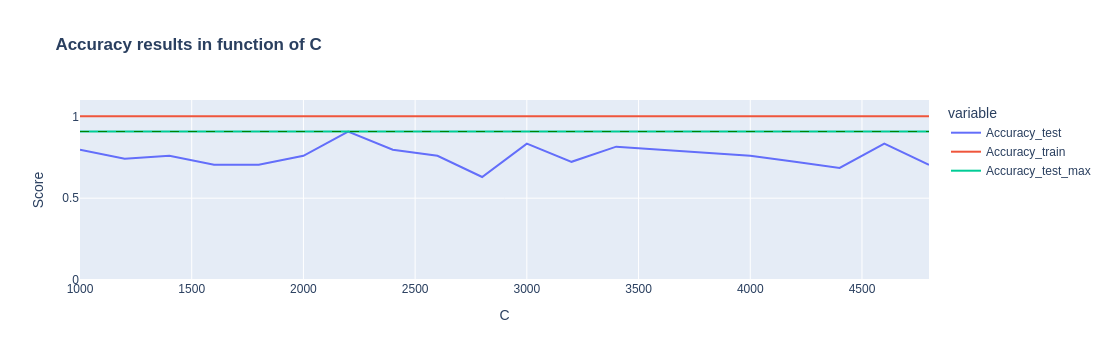

The best test score is : 0.9074074074074074


In [307]:
accuracy_plot(stft_scale_data_plot)

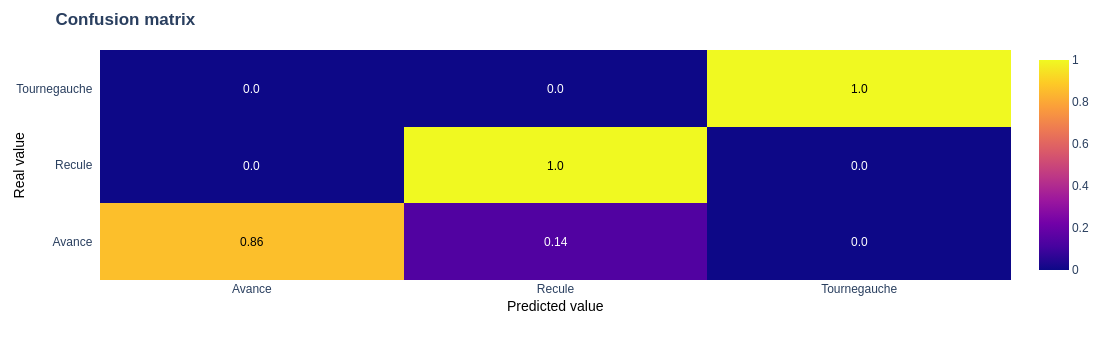

In [308]:
confusion_matrix_perso(stft_scale_data_plot)

<div class="alert alert-block alert-info">
By scaling our data, we obtain very good predictions. We obtain a maximum accuracy of 90%. And we see that our confusion matrix is ​​pretty accurate.</div>

<div class="alert alert-block alert-info">
Indeed, scaling data before performing logistic regression is important for several reasons:

- Improved Convergence: Scaling ensures that gradient descent converges faster and more reliably, as it helps in dealing with the different scales of the features.
- Coefficients Interpretation: When features are on the same scale, the coefficients can be more easily interpreted and compared.
- Avoiding Numerical Issues: Scaling helps prevent numerical problems that can arise from very large or very small values during the computation.
- Regularization: Regularization techniques like L1 or L2 regularization (used to prevent overfitting) work more effectively when the features are scaled.
- Distance-Based Algorithms: Logistic regression can be influenced by the distances between points in the feature space, which are more meaningful when the data is scaled.
</div>

## B) Cross validation using GridSearchCV

<div class="alert alert-block alert-info">
In a similar way, we find the previous results but using the functions already existing in Python. This will allow us to test different coefficients.</div>

### 1) Pipeline creation 

<div class="alert alert-block alert-info">
First, we need to create all the necessary pipelines.
    
- pipe_0 : logistic_regression
- pipe_1 : FFT + PCA + logistic_regression
- pipe_2 : FFT + scale + PCA + logistic_regression
- pipe_3 : STFT + logistic_regression
- pipe_4 : STFT + scale + logistic_regression
</div>

In [36]:
loo = LeaveOneOut() #cross validation
pca = PCA()
scaler = StandardScaler()
fft_class = FFT()
stft_class = STFT()
logistic = LogisticRegression(max_iter=10000)
pipe_reg_0 = Pipeline(steps=[("logistic", logistic)])
pipe_reg_1 = Pipeline(steps=[("fft", fft_class), ("pca", pca), ("logistic", logistic)])
pipe_reg_2 = Pipeline(steps=[("fft", fft_class), ("scaler", scaler), ("pca", pca), ("logistic", logistic)])
pipe_reg_3 = Pipeline(steps=[("stft", stft_class), ("logistic", logistic)])
pipe_reg_4 = Pipeline(steps=[("stft", stft_class), ("scaler", scaler), ("logistic", logistic)])

### 2) Param_grid

<div class="alert alert-block alert-info">
We then need to create the param_grid/values associated with each pipeline.</div>

In [37]:
param_grid_reg_0 = {
    "logistic__C": [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.4,1.6,1.8,2.0,5.0,10,100,500],
}

param_grid_reg_1 = {
    "pca__n_components": [15, 20],
    "logistic__C": [1, 2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125, 150, 200, 500],
}

param_grid_reg_2 = {
    "pca__n_components": [15, 20],
    "logistic__C": [1, 10, 50, 75, 80, 90, 100, 110, 120, 125, 150, 200, 500],
}

param_grid_reg_3 = {
    "logistic__C": [1, 10, 100, 500, 800, 900, 950, 1000, 1050, 1100, 1200, 1300, 1400, 1500],
    "stft__stat": [np.mean, np.max, np.median],
    "stft__idx_frequence_max": [90, 95, 100],
}

param_grid_reg_4 = {
    "logistic__C": [0.5, 1, 1.5, 2, 5, 10, 100, 500, 1000],
    "stft__stat": [np.mean, np.max, np.median],
    "stft__idx_frequence_max": [90, 95, 100],
}

### 3) Plot function

<div class="alert alert-block alert-info">
We have created additional functions to simplify the display.
    
- The <b>transform_clf</b> function allows you to take the output of a pipeline and turn it into a pandas dataframe.
- The <b>plot_score_time_clf</b> function displays time and score for each model.
- The <b>confusion_matrix_clf</b> function allows us to display the confusion matrix of the best estimator using a clf output.
- The <b>get_function_name</b> function transforms the function object into a string.
- The <b>get_grid_search_pipeline_string</b> function returns in the form of a string the list of operations of a pipeline.
- And <b>dataframe_model_summary</b> function returns informations for each pipeline best model.   </div>

In [44]:
def clf_transform(clf, pipe):
    scores = clf.cv_results_
    params_list = scores["params"]
    
    if pipe == "reg_0":
        params_strings = [f"C: {param['logistic__C']}" for param in params_list]
    if pipe == "reg_1":
        params_strings = [f"C: {param['logistic__C']}, N: {param['pca__n_components']}" for param in params_list]
    if pipe == "reg_1":
        params_strings = [f"C: {param['logistic__C']}, N: {param['pca__n_components']}" for param in params_list]
    if pipe == "reg_3":
        params_strings = [f"C: {param['logistic__C']}, stat: {param['stft__stat'].__name__}, idx_max: {param['stft__idx_frequence_max']}" for param in params_list]
    if pipe == "reg_4":
        params_strings = [f"C: {param['logistic__C']}, stat: {param['stft__stat'].__name__}, idx_max: {param['stft__idx_frequence_max']}" for param in params_list]
    if pipe == 'svm_l1':
        params_strings = [f"C: {param['SVM__C']}, kern: {param['SVM__kernel']}, N: {param['pca__n_components']}" for param in params_list]
    if pipe == 'svm_l2':
        params_strings = [f"C: {param['SVM__C']}, kern: {param['SVM__kernel']}, N: {param['pca__n_components']}" for param in params_list]
    if pipe == 'svm_l3':
        params_strings = [f"C: {param['SVM__C']}, kern: {param['SVM__kernel']}, stat: {param['stft__stat'].__name__}, idx_max: {param['stft__idx_frequence_max']}" for param in params_list]
    if pipe == 'svm_l4':
        params_strings = [f"C: {param['SVM__C']}, kern: {param['SVM__kernel']}, stat: {param['stft__stat'].__name__}, idx_max: {param['stft__idx_frequence_max']}" for param in params_list]
    if pipe == 'svm_g1':
        params_strings = [f"C: {param['SVM__C']}, kern: {param['SVM__kernel']}, G: {param['SVM__gamma']}, N: {param['pca__n_components']}" for param in params_list]
    if pipe == 'svm_g2':
        params_strings = [f"C: {param['SVM__C']}, kern: {param['SVM__kernel']}, G: {param['SVM__gamma']}, N: {param['pca__n_components']}" for param in params_list]
    if pipe == 'svm_g3':
        params_strings = [f"C: {param['SVM__C']}, kern: {param['SVM__kernel']}, G: {param['SVM__gamma']}, stat: {param['stft__stat'].__name__}, idx_max: {param['stft__idx_frequence_max']}" for param in params_list]
    if pipe == 'svm_g4':
        params_strings = [f"C: {param['SVM__C']}, kern: {param['SVM__kernel']}, G: {param['SVM__gamma']}, stat: {param['stft__stat'].__name__}, idx_max: {param['stft__idx_frequence_max']}" for param in params_list]
    if pipe == 'svm_p1':
        params_strings = [f"C: {param['SVM__C']}, kern: {param['SVM__kernel']}, G: {param['SVM__gamma']}, D: {param['SVM__degree']}, N: {param['pca__n_components']}" for param in params_list]
    if pipe == 'svm_p2':
        params_strings = [f"C: {param['SVM__C']}, kern: {param['SVM__kernel']}, G: {param['SVM__gamma']}, D: {param['SVM__degree']}, N: {param['pca__n_components']}" for param in params_list]
    if pipe == 'svm_p3':
        params_strings = [f"C: {param['SVM__C']}, kern: {param['SVM__kernel']}, G: {param['SVM__gamma']}, D: {param['SVM__degree']}, stat: {param['stft__stat'].__name__}, idx_max: {param['stft__idx_frequence_max']}" for param in params_list]
    if pipe == 'svm_p4':
        params_strings = [f"C: {param['SVM__C']}, kern: {param['SVM__kernel']}, G: {param['SVM__gamma']}, D: {param['SVM__degree']}, stat: {param['stft__stat'].__name__}, idx_max: {param['stft__idx_frequence_max']}" for param in params_list]

    tab_clf =  pd.DataFrame(
    {
        "Model" : params_strings, 
        "Mean_test_score" : scores["mean_test_score"],
        "Mean_train_score" : scores["mean_train_score"],
        "Mean_score_time" : scores["mean_score_time"],
        "Mean_fit_time" : scores["mean_fit_time"],
        "Total_time" : scores["mean_score_time"] + scores["mean_fit_time"],
    }).sort_values(['Mean_test_score', 'Total_time'], ascending = [False, True])
    
    return tab_clf, clf.best_params_, clf.best_score_

In [45]:
def plot_score_time_clf(tuple):
    df, best_params_, best_score_ = tuple
    
    fig = make_subplots(rows=2, cols=1, vertical_spacing=0.05)

    fig.append_trace(go.Scatter(
        x=df.Model,
        y=df.Mean_test_score,
        name = "Mean test score",
        mode='lines+markers',
    ), row=1, col=1)

    fig.append_trace(go.Scatter(
        x=df.Model,
        y=df.Mean_train_score,
        name = "Mean train score",
        mode='lines+markers',
    ), row=1, col=1)
    
    fig.append_trace(go.Scatter(
        x=df.Model,
        y=df.Total_time,
        name = "Execution time",
        mode='lines+markers',
    ), row=2, col=1)
    
    fig.update_layout(height=600, width=1000, title_text="<b>Score and execution time of each model</b>")
    fig.update_xaxes(
        showticklabels=False,
        row=1, col=1
    )
    fig.update_yaxes(
        title='Score',
        row=1, col=1,
        range = [0,1.1],
    )
    fig.update_xaxes(
        tickangle=-45,
        row=2, col=1,
        title = "Model",
    )
    fig.update_yaxes(
        title='Time <i>(s)</i>',
        row=2, col=1
    )
    fig.show()
    
    print("Best parameters:", best_params_)
    print("Best score:", best_score_)

In [1]:
def confusion_matrix_clf(clf, X_test, y_test):
    cm = confusion_matrix(y_test, clf.best_estimator_.predict(X_test))
    z = np.round(cm, 2)
    
    x = ['Avance', 'Recule', 'Tournegauche']
    y =  ['Avance', 'Recule', 'Tournegauche']
    
    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]
    
    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text)
    
    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                     )
    
    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Predicted value",
                            xref="paper",
                            yref="paper"))
    
    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=100))
    
    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.1,
                            y=0.5,
                            showarrow=False,
                            text="Real value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))
    
    # put the x_axis annotation on the bottom
    fig.update_layout(
        xaxis=dict(side='bottom')
    )
    
    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.show()

In [47]:
def get_function_name(func):
    return func.__name__ if callable(func) else func

In [48]:
def get_grid_search_pipeline_string(clf):
    
    best_estimator = clf.best_estimator_
    
    pipeline_steps = best_estimator.named_steps
    
    pipeline_string = ""
    
    for step_name, step_obj in pipeline_steps.items():
        pipeline_string += f"{step_name} "
    
    return pipeline_string

In [49]:
def dataframe_model_summary(list_clf):
    param_list = []
    model_list = []
    best_score_train_list = []
    for i in list_clf:
        param_list.append(i.best_params_)
        model_list.append(get_grid_search_pipeline_string(i))
        best_score_train_list.append(i.best_score_)
    
    if not param_list:
        return pd.DataFrame()
    df_models = pd.DataFrame(
    {
        "Pipeline" : model_list, 
        "Train score" : best_score_train_list,
    }
    )
    df_params = pd.DataFrame(param_list)
    df_combined = pd.concat([df_models, df_params], axis=1)
    df_combined['stft__stat'] = df_combined['stft__stat'].apply(get_function_name)
    return df_combined

### 4) Train/test separation  

<div class="alert alert-block alert-info">
We use the same separation for each of our tests. We arbitrarily choose a text_size of 0.3. But it could have been interesting to analyze the influence of text_size.</div>

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 5) Results on initial data

<div class="alert alert-block alert-info">
First of all, we will only apply a logistic regression.</div>

In [52]:
clf_reg_0 = GridSearchCV(pipe_reg_0, param_grid_reg_0, cv=loo, return_train_score=True)

In [53]:
clf_reg_0.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('logistic',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logistic__C': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                         1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10,
                                         100, 500]},
             return_train_score=True)

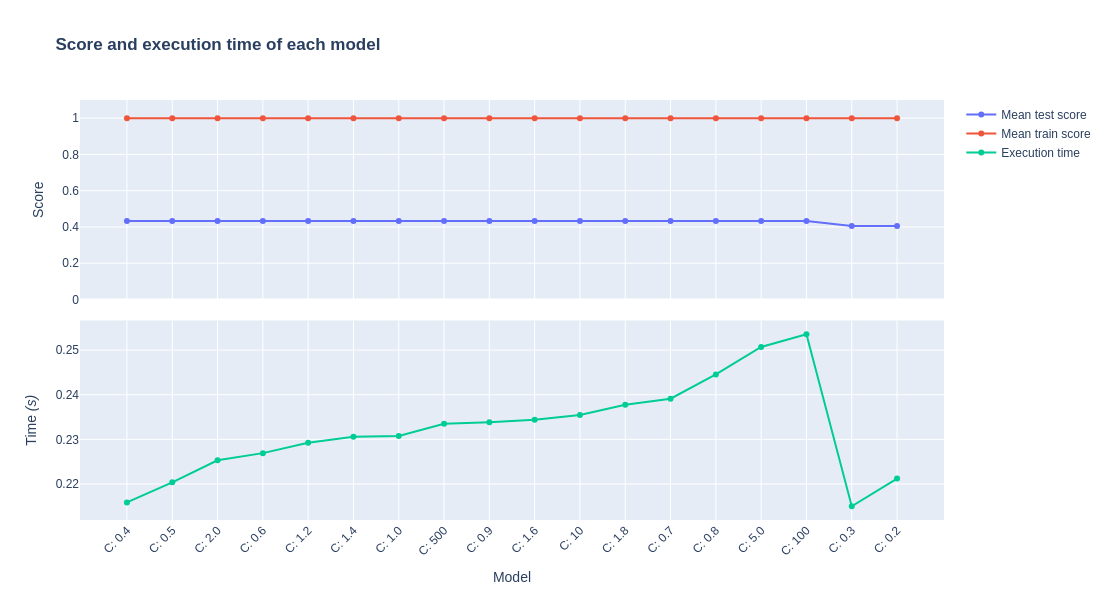

Best parameters: {'logistic__C': 0.4}
Best score: 0.43243243243243246


In [55]:
plot_score_time_clf(clf_transform(clf_reg_0, "reg_0"))

<div class="alert alert-block alert-warning">
We have also here a overfitting problem. In addition, we see that the prediction depends enormously on the training data. As we have a small data set, we may not obtain all of our tags with the train/test set. For example on the confusion matrix below, all our data is tagged  “Recule”.</div>

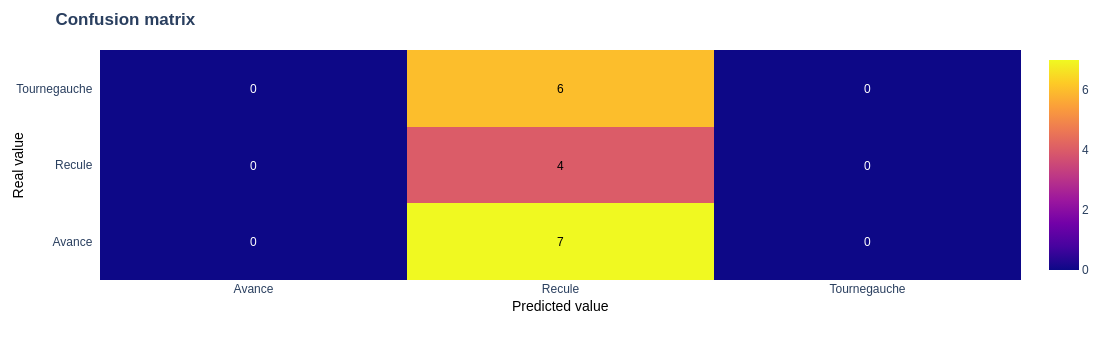

In [56]:
confusion_matrix_clf(clf_reg_0, X_test, y_test)

### 6) Results on FFT + PCA data

In [57]:
clf_reg_1 = GridSearchCV(pipe_reg_1, param_grid_reg_1, cv=loo, return_train_score=True)

In [58]:
clf_reg_1.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('fft', FFT()), ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logistic__C': [1, 2, 5, 10, 15, 20, 30, 40, 50, 75,
                                         100, 125, 150, 200, 500],
                         'pca__n_components': [15, 20]},
             return_train_score=True)

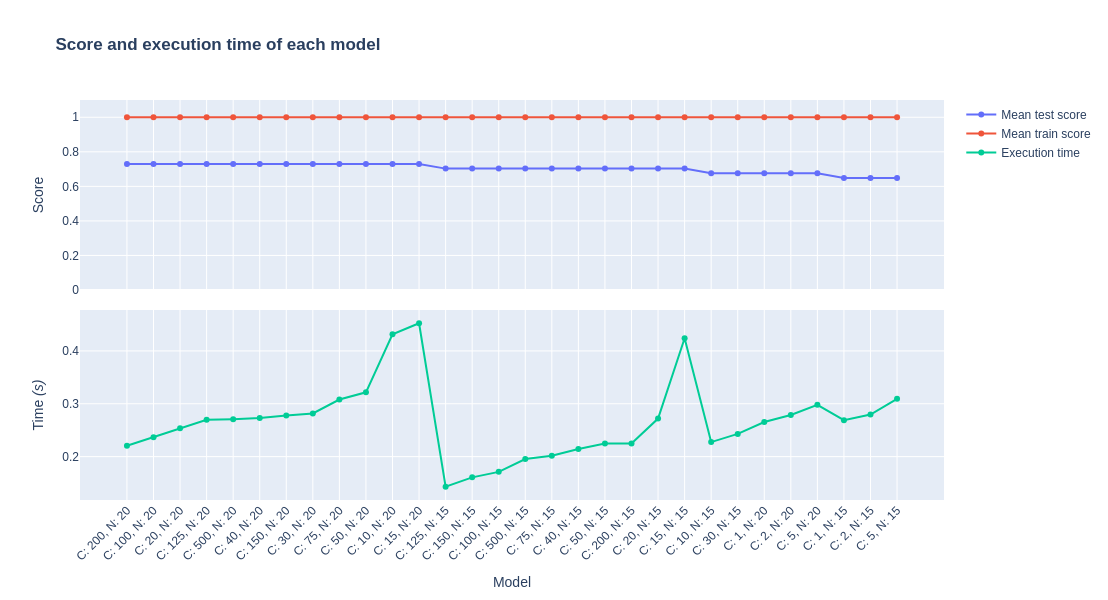

Best parameters: {'logistic__C': 10, 'pca__n_components': 20}
Best score: 0.7297297297297297


In [59]:
plot_score_time_clf(clf_transform(clf_reg_1, "reg_1"))

<div class="alert alert-block alert-info">
We can note that the best estimator is not necessarily the same as what we find with the graph above. We also see an overfitting problem but the test scores are higher than for simple logistic regression.</div>

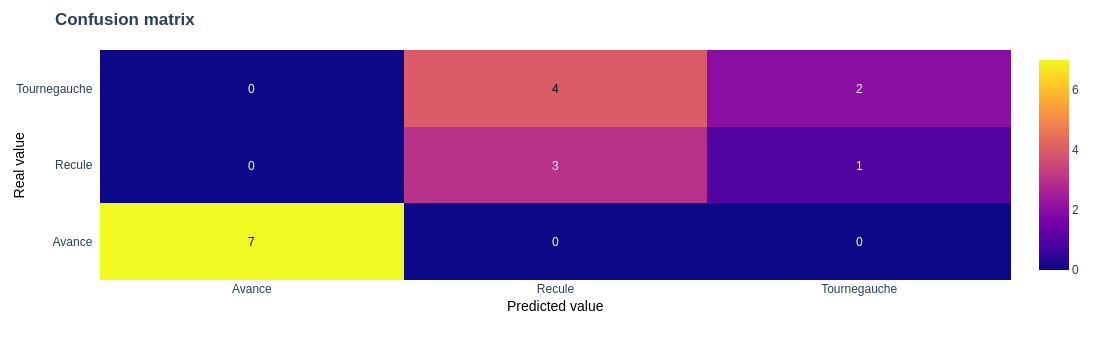

In [60]:
confusion_matrix_clf(clf_reg_1, X_test, y_test)

### 7) Results on FFT + Scale + PCA data

In [289]:
clf_reg_2 = GridSearchCV(pipe_reg_2, param_grid_reg_2, cv=loo, return_train_score=True)

In [290]:
clf_reg_2.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('fft', FFT()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logistic__C': [1, 10, 50, 75, 80, 90, 100, 110, 120,
                                         125, 150, 200, 500],
                         'pca__n_components': [15, 20]},
             return_train_score=True)

<div class="alert alert-block alert-info">
TO DO</div>

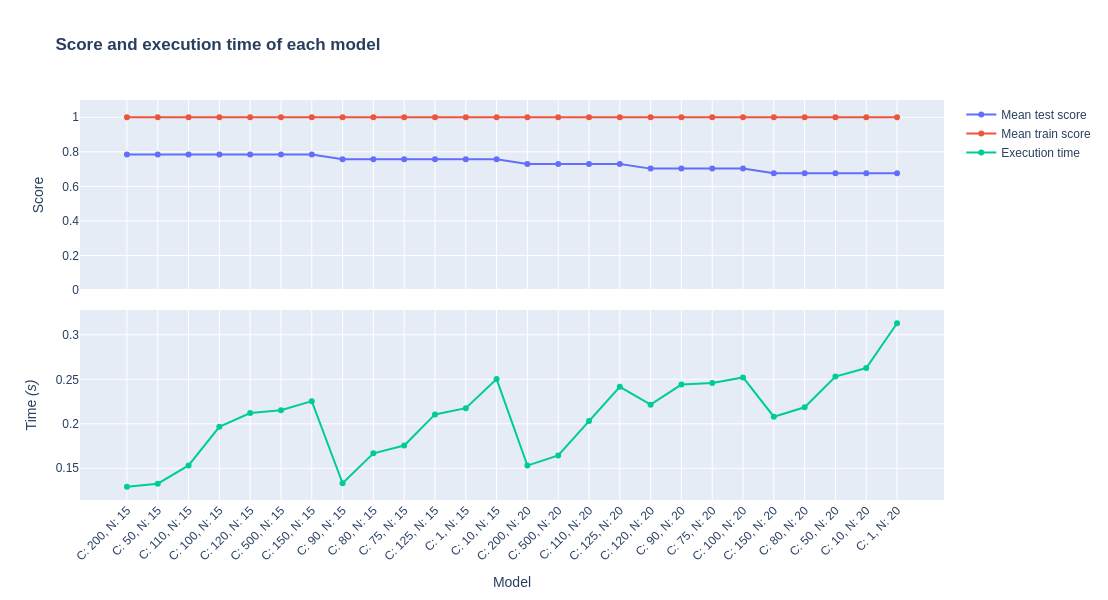

Best parameters: {'logistic__C': 50, 'pca__n_components': 15}
Best score: 0.7837837837837838


In [291]:
plot_score_time_clf(clf_transform(clf_reg_2,"reg_2"))

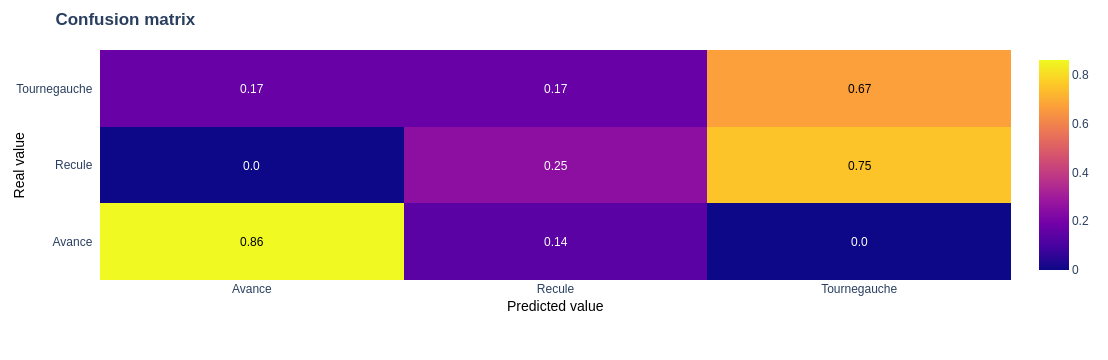

In [292]:
confusion_matrix_clf(clf_reg_2, X_test, y_test)

### 8) Results on STFT data

In [319]:
clf_reg_3 = GridSearchCV(pipe_reg_3, param_grid_reg_3, cv=loo, return_train_score=True)

In [320]:
clf_reg_3.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('stft',
                                        <__main__.STFT object at 0x7fb8fda5fd00>),
                                       ('logistic',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logistic__C': [1, 10, 100, 500, 800, 900, 950, 1000,
                                         1050, 1100, 1200, 1300, 1400, 1500],
                         'stft__idx_frequence_max': [90, 95, 100],
                         'stft__stat': [<function mean at 0x7fb92c2ce270>,
                                        <function max at 0x7fb92c2cce70>,
                                        <function median at 0x7fb92c1d9630>]},
             return_train_score=True)

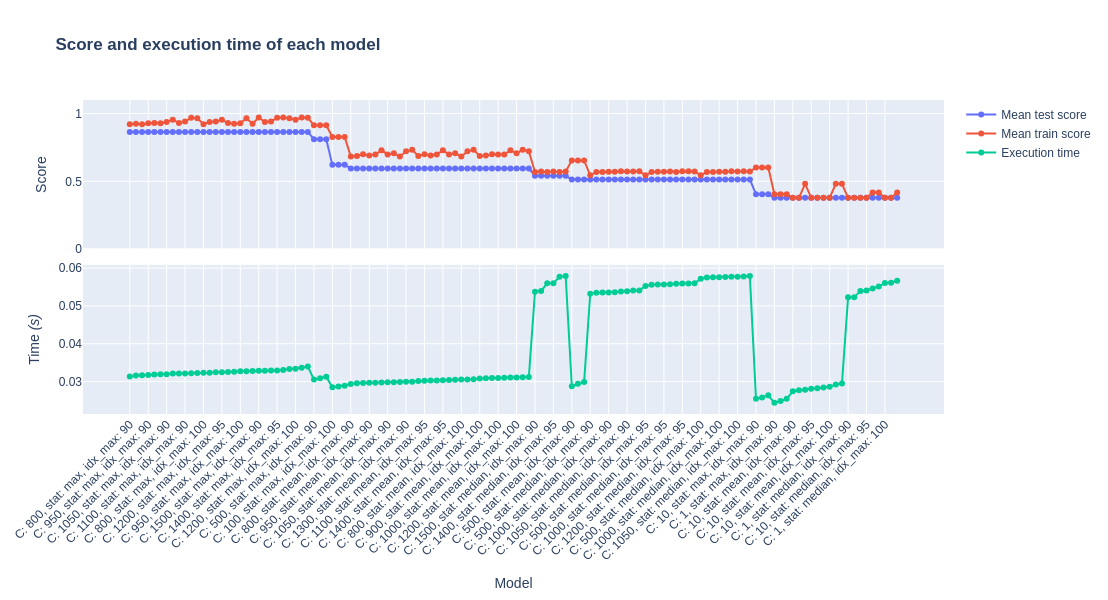

Best parameters: {'logistic__C': 800, 'stft__idx_frequence_max': 90, 'stft__stat': <function max at 0x7fb92c2cce70>}
Best score: 0.8648648648648649


In [321]:
plot_score_time_clf(clf_transform(clf_reg_3, "reg_3"))

<div class="alert alert-block alert-info">
TO DO</div>

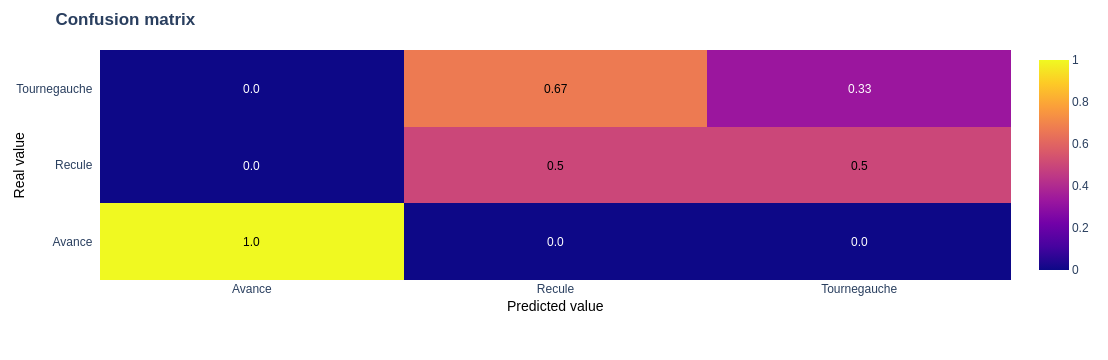

In [322]:
confusion_matrix_clf(clf_reg_3, X_test, y_test)

### 9) Results on STFT + Scale data

In [323]:
clf_reg_4 = GridSearchCV(pipe_reg_4, param_grid_reg_4, cv=loo, return_train_score=True)

In [324]:
clf_reg_4.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('stft',
                                        <__main__.STFT object at 0x7fb8fda5fd00>),
                                       ('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logistic__C': [0.5, 1, 1.5, 2, 5, 10, 100, 500, 1000],
                         'stft__idx_frequence_max': [90, 95, 100],
                         'stft__stat': [<function mean at 0x7fb92c2ce270>,
                                        <function max at 0x7fb92c2cce70>,
                                        <function median at 0x7fb92c1d9630>]},
             return_train_score=True)

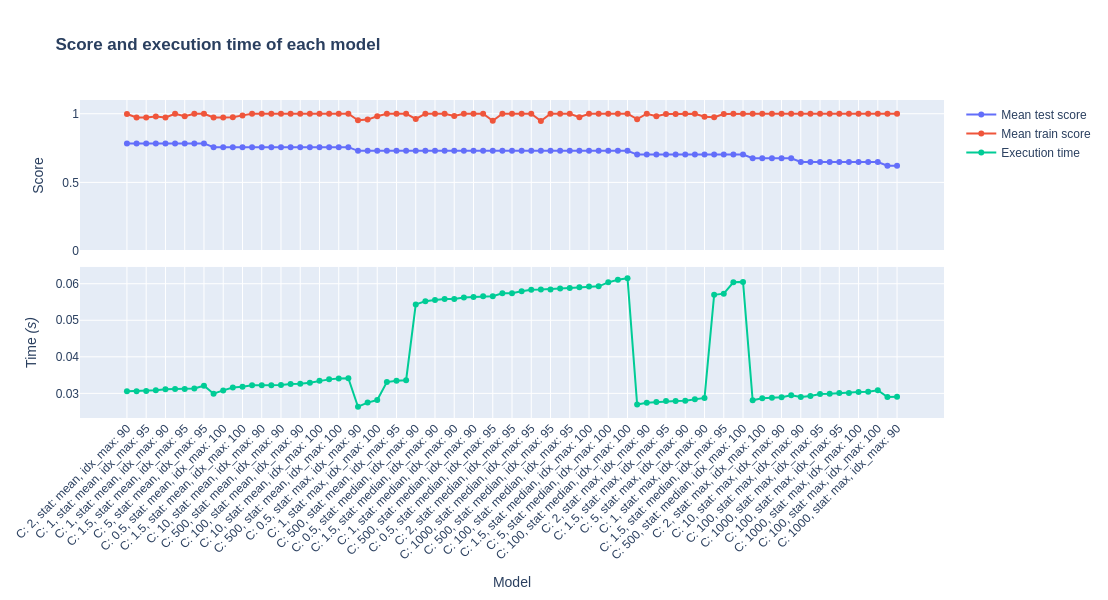

Best parameters: {'logistic__C': 0.5, 'stft__idx_frequence_max': 95, 'stft__stat': <function mean at 0x7fb92c2ce270>}
Best score: 0.7837837837837838


In [325]:
plot_score_time_clf(clf_transform(clf_reg_4, "reg_4"))

<div class="alert alert-block alert-info">
TO DO</div>

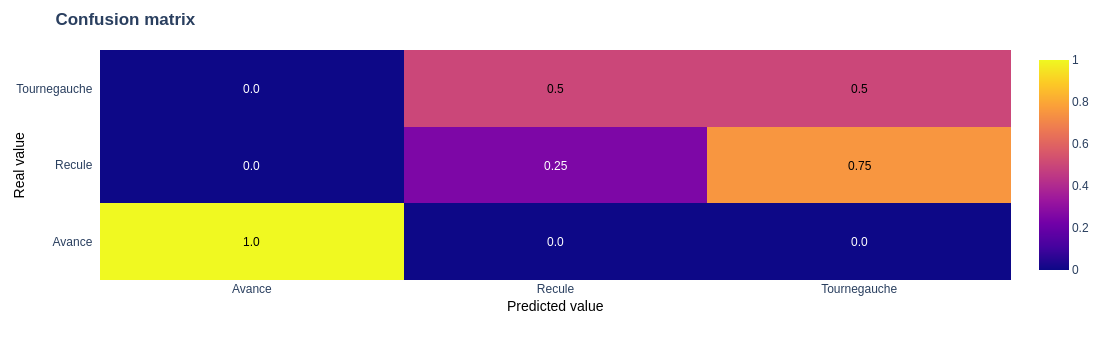

In [326]:
confusion_matrix_clf(clf_reg_4, X_test, y_test)

### 10) Summary of our models

In [342]:
clf_list = [clf_0, clf_1, clf_2, clf_3, clf_4]
df_summary = dataframe_model_summary(clf_list)

<div class="alert alert-block alert-info">
TO DO</div>

In [349]:
df_summary

Pipeline  Train score  logistic__C  pca__n_components  \
0                 logistic      0.432432          0.4                NaN   
1         fft pca logistic      0.729730         10.0               20.0   
2  fft scaler pca logistic      0.783784         50.0               15.0   
3            stft logistic      0.864865        800.0                NaN   
4     stft scaler logistic      0.783784          0.5                NaN   

   stft__idx_frequence_max stft__stat stat_function_name  
0                      NaN        NaN                NaN  
1                      NaN        NaN                NaN  
2                      NaN        NaN                NaN  
3                     90.0        max                max  
4                     95.0       mean               mean

# III) Classification by kernel methods


<div class="alert alert-block alert-info">
In this part, we will focus on classification by SVM. We will test different kernels and compare their effect on the data.</div>

## A) Pipeline creation

<div class="alert alert-block alert-info">
We create 4 pipelines which we will vary with each kernel.</div>

In [61]:
loo = LeaveOneOut() #cross validation
pca = PCA()
scaler = StandardScaler()
fft_class = FFT()
stft_class = STFT()
SVM = SVC()

In [62]:
pipe_svm_1 = Pipeline(steps=[("fft", fft_class), ("pca", pca), ("SVM", SVM)])
pipe_svm_2 = Pipeline(steps=[("fft", fft_class), ("scaler", scaler), ("pca", pca), ("SVM", SVM)])
pipe_svm_3 = Pipeline(steps=[("stft", stft_class), ("SVM", SVM)])
pipe_svm_4 = Pipeline(steps=[("stft", stft_class), ("scaler", scaler), ("SVM", SVM)])

## B) Param_grid

<div class="alert alert-block alert-info">
We create our param_grid by iterations. That is to say, we run the program once to get an idea of ​​the coefficients and then ajust them as we go.</div>

### 1) For linear kernel

In [97]:
### for fft + pca
param_grid_svm_lin_1 = {
    "pca__n_components": [15, 17, 20],
    "SVM__kernel": ['linear'],
    "SVM__C": [0.1,0.3,0.5,1,1.5,5,10,15,20,25,30,40,50,100],
}

### for fft + scale + pca
param_grid_svm_lin_2 = {
    "pca__n_components": [15, 17, 20],
    "SVM__kernel": ['linear'],
    "SVM__C": [0.1,0.3,0.5,1,1.5,5,10,15,20,25,30,40,50,100],
}

### for stft
param_grid_svm_lin_3 = {
    "stft__stat": [np.max, np.mean, np.median],
    "stft__idx_frequence_max": [75, 80, 85, 90, 95],
    "SVM__kernel": ['linear'],
    "SVM__C": [1,10,50,100,200,500,1000,1500,2000,3000],
}

### for stft + scale
param_grid_svm_lin_4 = {
    "stft__stat": [np.max, np.mean, np.median],
    "stft__idx_frequence_max": [80, 90, 95],
    "SVM__kernel": ['linear'],
    "SVM__C": [0.1,0.5,1,1.5,2,5,10,20,50,100],
}

### 2) For gaussian kernel

In [96]:
### for fft + pca
param_grid_svm_gaus_1 = {
    "pca__n_components": [15, 17, 20],
    "SVM__kernel": ['rbf'],
    "SVM__C": [0.1,1,5,10,20,50,100,200,500,1000, 2000],
    "SVM__gamma": ['scale', 'auto', 1] ,
}

### for fft + scale + pca
param_grid_svm_gaus_2 = {
    "pca__n_components": [15, 17, 20],
    "SVM__kernel": ['rbf'],
    "SVM__C": [0.1,1,5,10,20,50,100,200,500,1000, 2000],
    "SVM__gamma": ['scale', 'auto', 1] ,
}

### for stft
param_grid_svm_gaus_3 = {
    "stft__stat": [np.max, np.mean, np.median],
    "stft__idx_frequence_max": [80, 90, 95],
    "SVM__kernel": ['rbf'],
    "SVM__C": [0.1,1,5,10,20,50,100,200,500,1000, 2000],
    "SVM__gamma": ['scale', 'auto', 1] ,
}

### for stft + scale
param_grid_svm_gaus_4 = {
    "stft__stat": [np.max, np.mean, np.median],
    "stft__idx_frequence_max": [80, 90, 95],
    "SVM__kernel": ['rbf'],
    "SVM__C": [0.1,1,5,10,20,50,100,200,500,1000, 2000],
    "SVM__gamma": ['scale', 'auto', 1] ,
}

### 3) For polynomial kernel

In [94]:
### for fft + pca
param_grid_svm_poly_1 = {
    "pca__n_components": [15, 20],
    "SVM__kernel": ['poly'],
    "SVM__C": [1,10,50,100,500,1000],
    "SVM__gamma": ['scale', 'auto'],
    "SVM__degree": [3, 4],

}

### for fft + scale + pca
param_grid_svm_poly_2 = {
    "pca__n_components": [15, 20],
    "SVM__kernel": ['poly'],
    "SVM__C": [1,10,50,100,500,1000],
    "SVM__gamma": ['scale', 'auto'] ,
    "SVM__degree": [3, 4],
}

### for stft
param_grid_svm_poly_3 = {
    "stft__stat": [np.max, np.mean, np.median],
    "stft__idx_frequence_max": [80, 90, 95],
    "SVM__kernel": ['poly'],
    "SVM__C": [1,10,50,100,500,1000],
    "SVM__gamma": ['scale', 'auto'] ,
    "SVM__degree": [3, 4],
}

### for stft + scale
param_grid_svm_poly_4 = {
    "stft__stat": [np.max, np.mean, np.median],
    "stft__idx_frequence_max": [80, 90, 95],
    "SVM__kernel": ['poly'],
    "SVM__C": [1,10,50,100,500,1000],
    "SVM__gamma": ['scale', 'auto'],
    "SVM__degree": [3, 4],
}

## C) Linear kernel

<div class="alert alert-block alert-info">
We use the same X_train, y_train, X_test, y_test as previously.</div>

### 1) Results for FFT + PCA data

<div class="alert alert-block alert-info">
TO DO</div>

In [66]:
clf_svm_lin_1 = GridSearchCV(pipe_svm_1, param_grid_svm_lin_1, cv=loo, return_train_score=True)

In [67]:
clf_svm_lin_1.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('fft', FFT()), ('pca', PCA()),
                                       ('SVM', SVC())]),
             param_grid={'SVM__C': [0.1, 0.3, 0.5, 1, 1.5, 5, 10, 15, 20, 25,
                                    30, 40, 50, 100],
                         'SVM__kernel': ['linear'],
                         'pca__n_components': [15, 17, 20]},
             return_train_score=True)

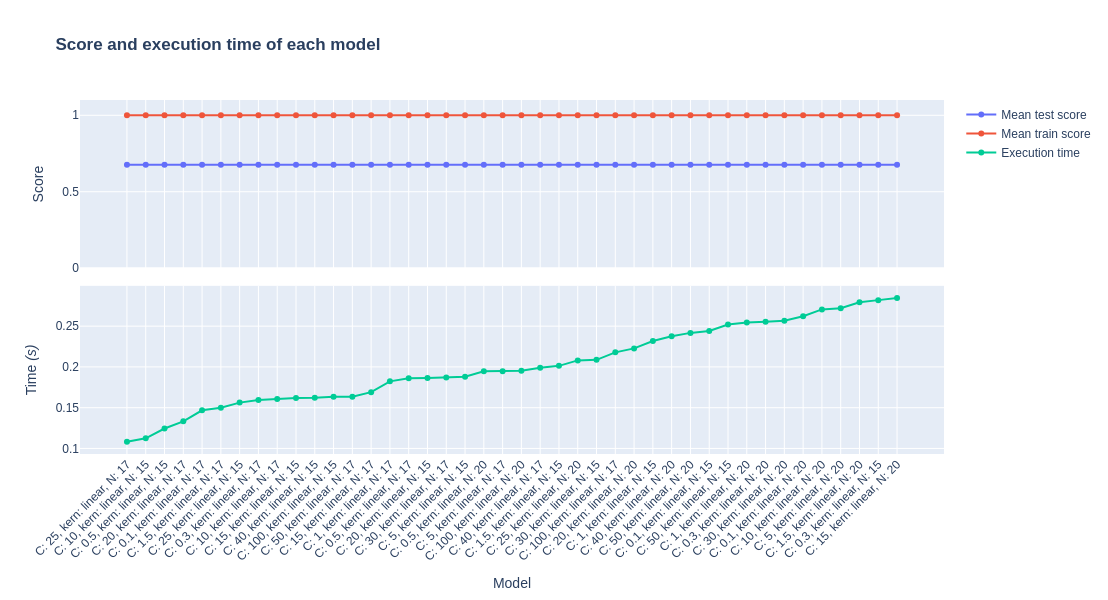

Best parameters: {'SVM__C': 0.1, 'SVM__kernel': 'linear', 'pca__n_components': 15}
Best score: 0.6756756756756757


In [68]:
plot_score_time_clf(clf_transform(clf_svm_lin_1,'svm_l1'))

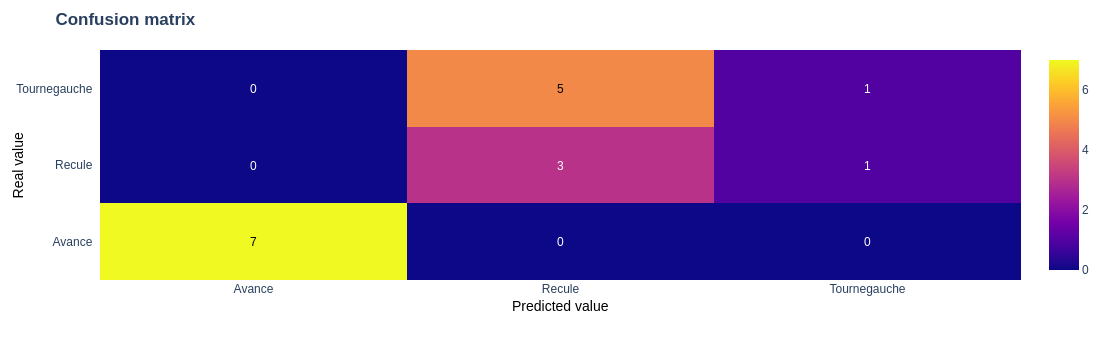

In [73]:
confusion_matrix_clf(clf_svm_lin_1, X_test, y_test)

### 2) Results for FFT + Scale + PCA data

<div class="alert alert-block alert-info">
TO DO</div>

In [123]:
clf_svm_lin_2 = GridSearchCV(pipe_svm_2, param_grid_svm_lin_2, cv=loo, return_train_score=True)

In [124]:
clf_svm_lin_2.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('fft', FFT()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()), ('SVM', SVC())]),
             param_grid={'SVM__C': [0.1, 0.3, 0.5, 1, 1.5, 5, 10, 15, 20, 25,
                                    30, 40, 50, 100],
                         'SVM__kernel': ['linear'],
                         'pca__n_components': [15, 17, 20]},
             return_train_score=True)

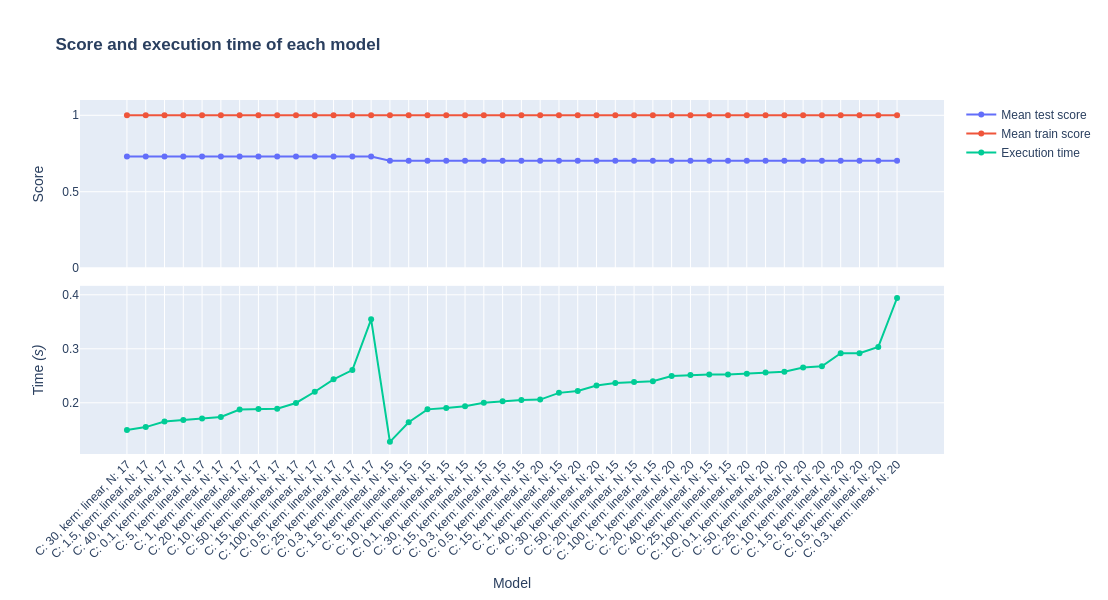

Best parameters: {'SVM__C': 0.1, 'SVM__kernel': 'linear', 'pca__n_components': 17}
Best score: 0.7297297297297297


In [125]:
plot_score_time_clf(clf_transform(clf_svm_lin_2,'svm_l2'))

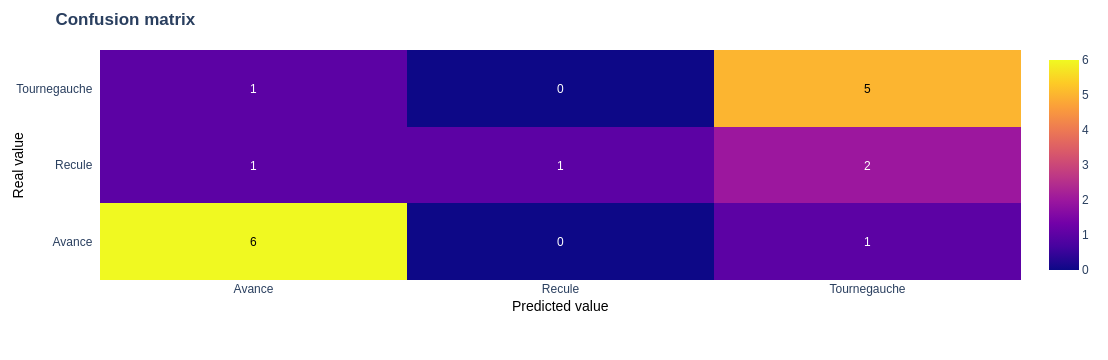

In [126]:
confusion_matrix_clf(clf_svm_lin_2, X_test, y_test)

### 3) Results for STFT data

<div class="alert alert-block alert-info">
TO DO</div>

In [127]:
clf_svm_lin_3 = GridSearchCV(pipe_svm_3, param_grid_svm_lin_3, cv=loo, return_train_score=True)

In [128]:
clf_svm_lin_3.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('stft',
                                        <__main__.STFT object at 0x7f2c0334c7f0>),
                                       ('SVM', SVC())]),
             param_grid={'SVM__C': [1, 10, 50, 100, 200, 500, 1000, 1500, 2000,
                                    3000],
                         'SVM__kernel': ['linear'],
                         'stft__idx_frequence_max': [75, 80, 85, 90, 95],
                         'stft__stat': [<function max at 0x7f2c303bb870>,
                                        <function mean at 0x7f2c303c8c70>,
                                        <function median at 0x7f2c302ea6b0>]},
             return_train_score=True)

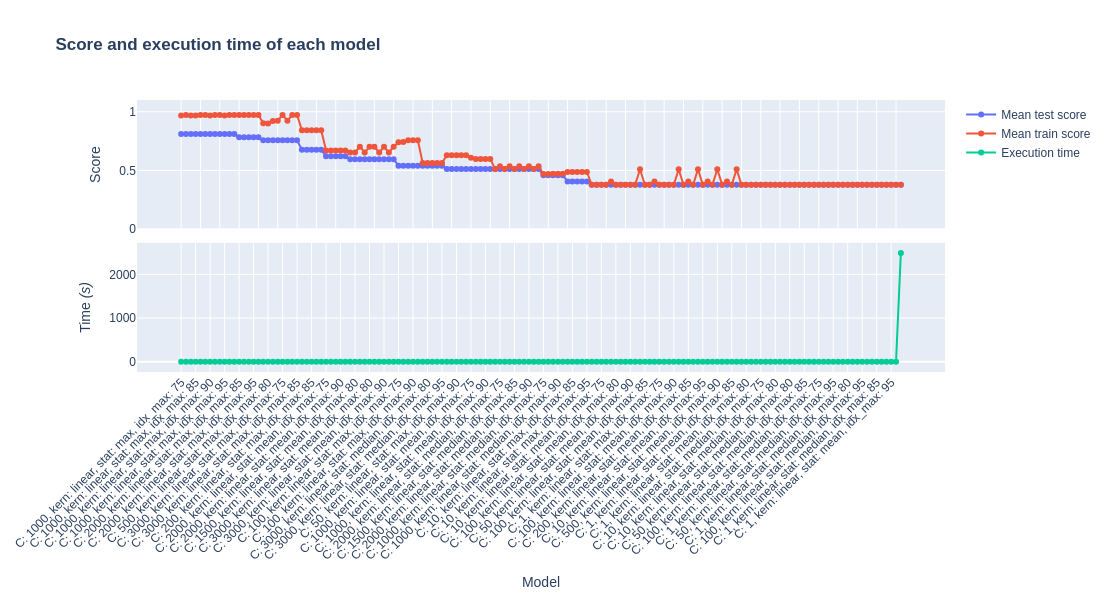

Best parameters: {'SVM__C': 1000, 'SVM__kernel': 'linear', 'stft__idx_frequence_max': 75, 'stft__stat': <function max at 0x7f2c303bb870>}
Best score: 0.8108108108108109


In [ ]:
plot_score_time_clf(clf_transform(clf_svm_lin_3,'svm_l3'))

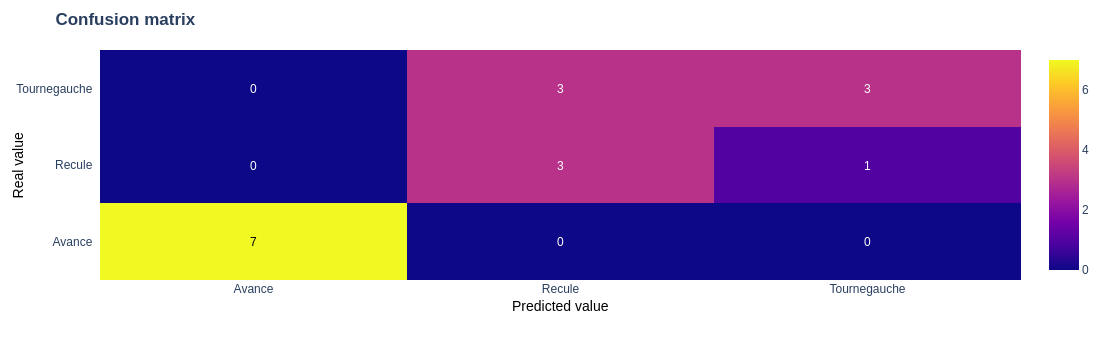

In [ ]:
confusion_matrix_clf(clf_svm_lin_3, X_test, y_test)

### 4) Results for STFT + Scale data

<div class="alert alert-block alert-info">
TO DO</div>

In [43]:
clf_svm_lin_4 = GridSearchCV(pipe_svm_4, param_grid_svm_lin_4, cv=loo, return_train_score=True)

In [44]:
clf_svm_lin_4.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('stft',
                                        <__main__.STFT object at 0x7f0aabaf1450>),
                                       ('scaler', StandardScaler()),
                                       ('SVM', SVC())]),
             param_grid={'SVM__C': [0.1, 0.5, 1, 1.5, 2, 5, 10, 20, 50, 100],
                         'SVM__kernel': ['linear'],
                         'stft__idx_frequence_max': [80, 90, 95],
                         'stft__stat': [<function max at 0x7f0ad856a2b0>,
                                        <function mean at 0x7f0ad856b670>,
                                        <function median at 0x7f0ad8004930>]},
             return_train_score=True)

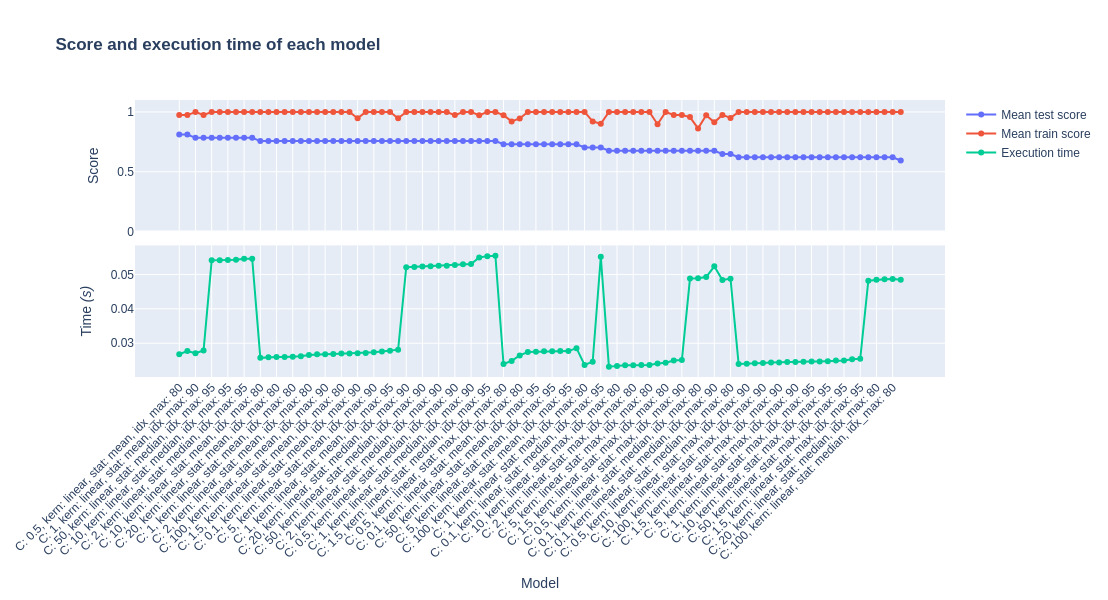

Best parameters: {'SVM__C': 0.5, 'SVM__kernel': 'linear', 'stft__idx_frequence_max': 80, 'stft__stat': <function mean at 0x7f0ad856b670>}
Best score: 0.8108108108108109


In [63]:
plot_score_time_clf(clf_transform(clf_svm_lin_4,'svm_l4'))

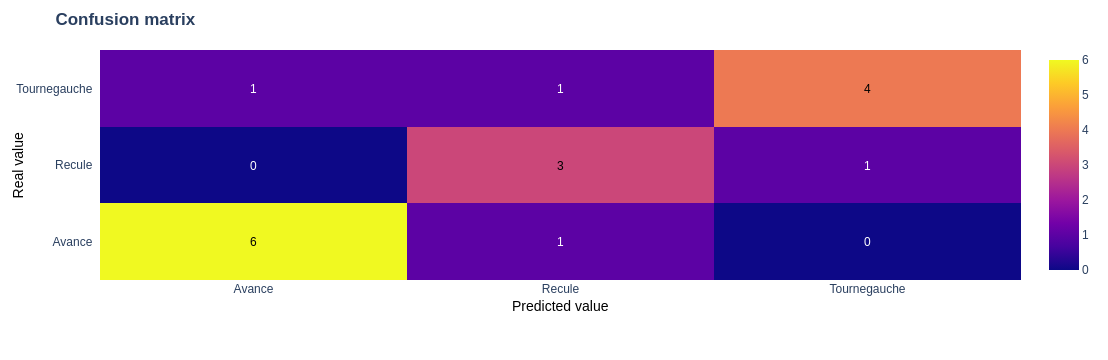

In [64]:
confusion_matrix_clf(clf_svm_lin_4, X_test, y_test)

### 5) Summary tab

<div class="alert alert-block alert-info">
As before, we display a summary table.</div>

In [65]:
clf_svm_lin_list = [clf_svm_lin_1, clf_svm_lin_2, clf_svm_lin_3, clf_svm_lin_4]
df_summary_svm_lin = dataframe_model_summary(clf_svm_lin_list)

In [66]:
df_summary_svm_lin

Pipeline  Train score  SVM__C SVM__kernel  pca__n_components  \
0         fft pca SVM      0.675676     0.1      linear               15.0   
1  fft scaler pca SVM      0.729730     0.1      linear               17.0   
2            stft SVM      0.810811  1000.0      linear                NaN   
3     stft scaler SVM      0.810811     0.5      linear                NaN   

   stft__idx_frequence_max stft__stat  
0                      NaN        NaN  
1                      NaN        NaN  
2                     75.0        max  
3                     80.0       mean

## D) Gaussian kernel

### 1) Results for FFT + PCA data

<div class="alert alert-block alert-info">
TO DO</div>

In [74]:
clf_svm_gaus_1 = GridSearchCV(pipe_svm_1, param_grid_svm_gaus_1, cv=loo, return_train_score=True)

In [75]:
clf_svm_gaus_1.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('fft', FFT()), ('pca', PCA()),
                                       ('SVM', SVC())]),
             param_grid={'SVM__C': [0.1, 1, 5, 10, 20, 50, 100, 200, 500, 1000,
                                    2000],
                         'SVM__gamma': ['scale', 'auto', 1],
                         'SVM__kernel': ['rbf'],
                         'pca__n_components': [15, 17, 20]},
             return_train_score=True)

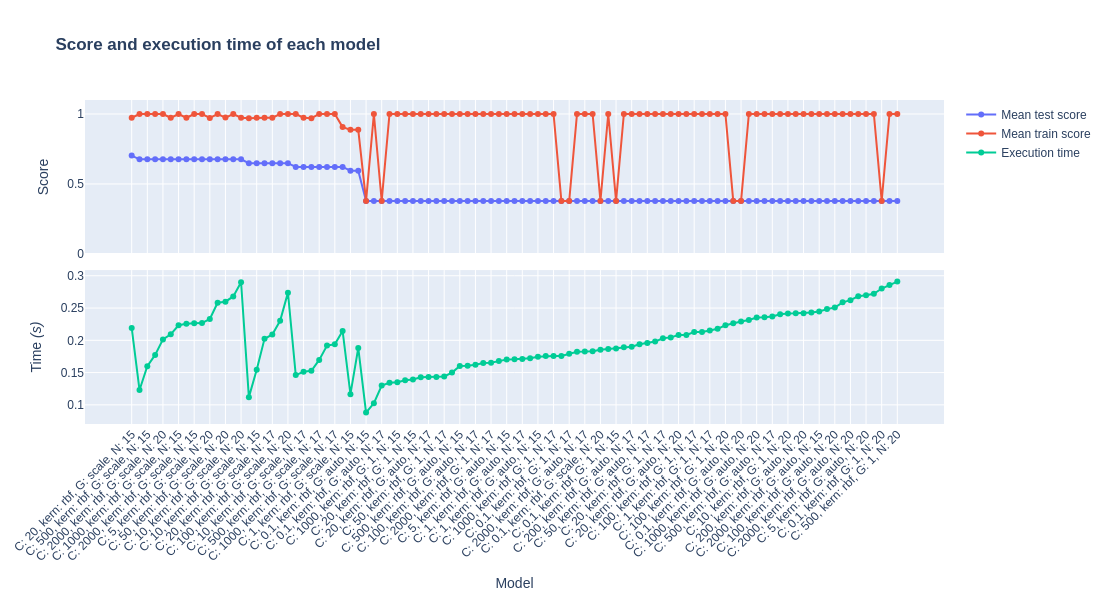

Best parameters: {'SVM__C': 20, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf', 'pca__n_components': 15}
Best score: 0.7027027027027027


In [76]:
plot_score_time_clf(clf_transform(clf_svm_gaus_1,'svm_g1'))

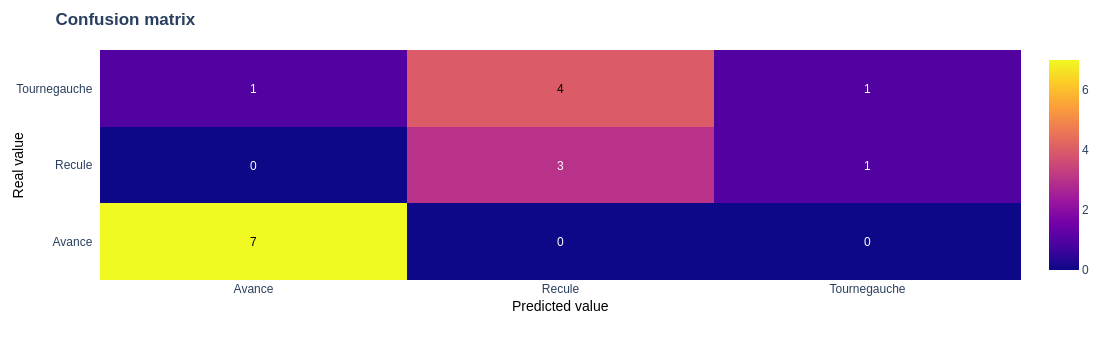

In [89]:
confusion_matrix_clf(clf_svm_gaus_1, X_test, y_test)

### 2) Results for FFT + Scale + PCA data

<div class="alert alert-block alert-info">
TO DO</div>

In [78]:
clf_svm_gaus_2 = GridSearchCV(pipe_svm_2, param_grid_svm_gaus_2, cv=loo, return_train_score=True)

In [79]:
clf_svm_gaus_2.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('fft', FFT()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()), ('SVM', SVC())]),
             param_grid={'SVM__C': [0.1, 1, 5, 10, 20, 50, 100, 200, 500, 1000,
                                    2000],
                         'SVM__gamma': ['scale', 'auto', 1],
                         'SVM__kernel': ['rbf'],
                         'pca__n_components': [15, 17, 20]},
             return_train_score=True)

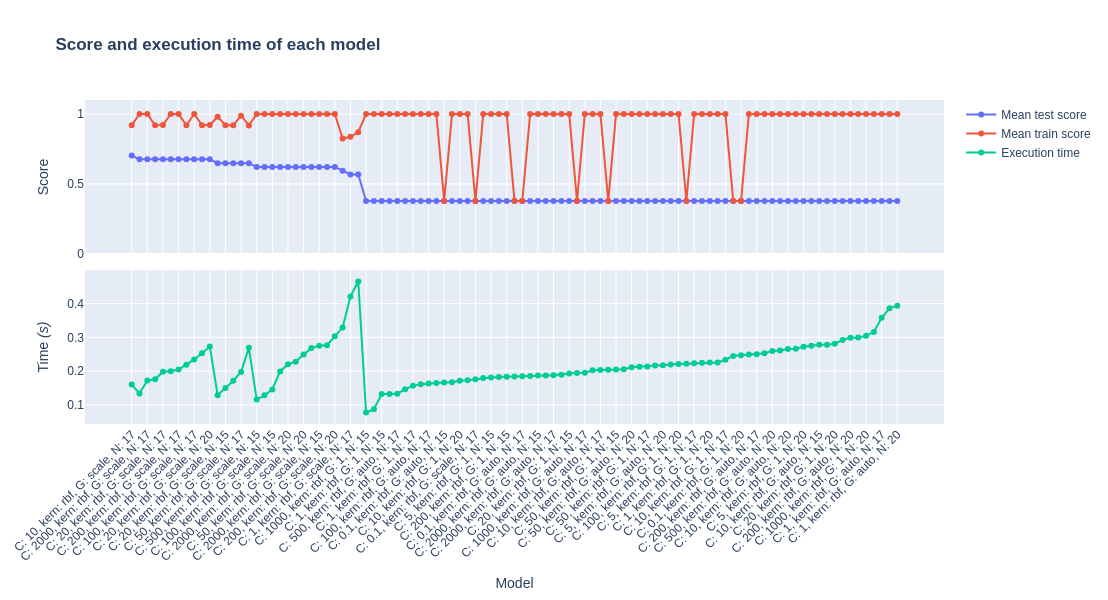

Best parameters: {'SVM__C': 10, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf', 'pca__n_components': 17}
Best score: 0.7027027027027027


In [80]:
plot_score_time_clf(clf_transform(clf_svm_gaus_2,'svm_g2'))

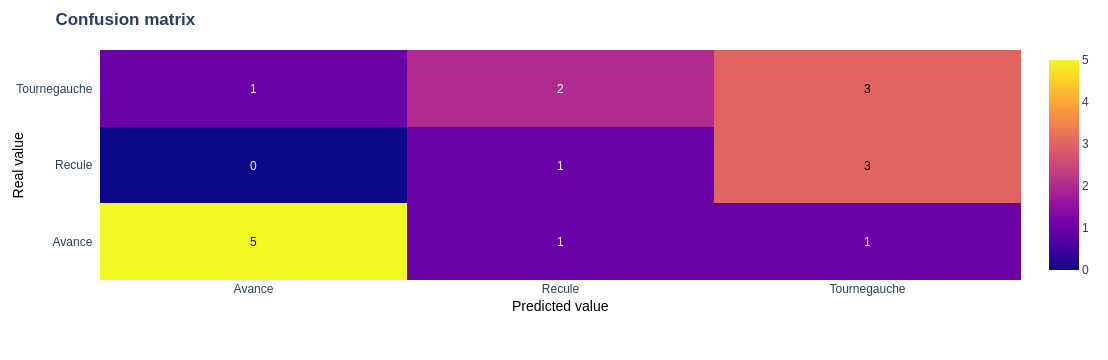

In [90]:
confusion_matrix_clf(clf_svm_gaus_2, X_test, y_test)

### 3) Results for STFT data

<div class="alert alert-block alert-info">
TO DO</div>

In [82]:
clf_svm_gaus_3 = GridSearchCV(pipe_svm_3, param_grid_svm_gaus_3, cv=loo, return_train_score=True)

In [83]:
clf_svm_gaus_3.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('stft',
                                        <__main__.STFT object at 0x7f2c0334c7f0>),
                                       ('SVM', SVC())]),
             param_grid={'SVM__C': [0.1, 1, 5, 10, 20, 50, 100, 200, 500, 1000,
                                    2000],
                         'SVM__gamma': ['scale', 'auto', 1],
                         'SVM__kernel': ['rbf'],
                         'stft__idx_frequence_max': [80, 90, 95],
                         'stft__stat': [<function max at 0x7f2c303bb870>,
                                        <function mean at 0x7f2c303c8c70>,
                                        <function median at 0x7f2c302ea6b0>]},
             return_train_score=True)

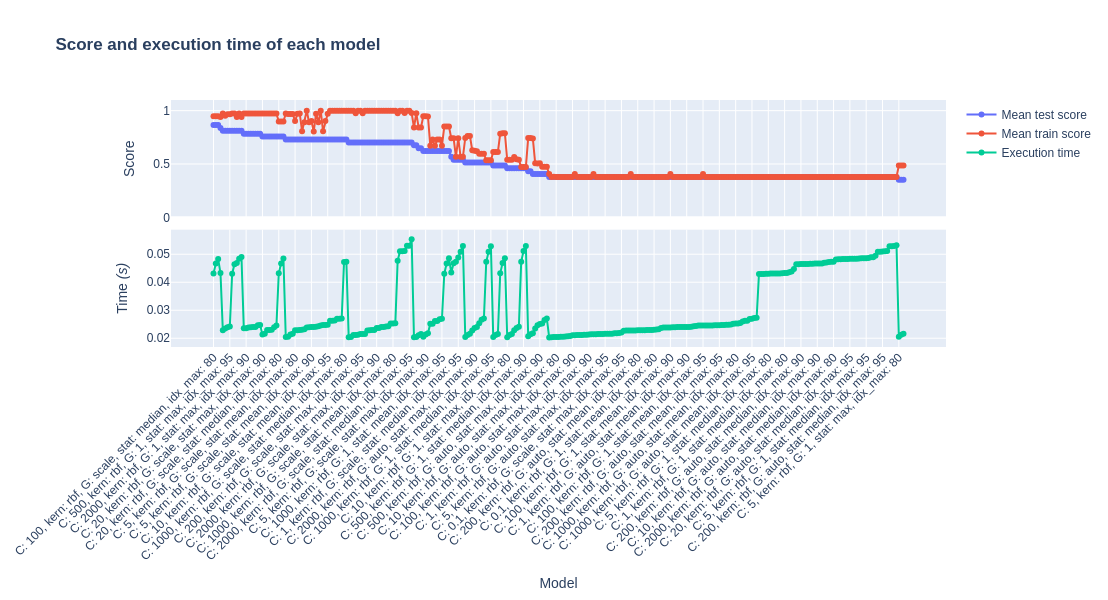

Best parameters: {'SVM__C': 100, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf', 'stft__idx_frequence_max': 80, 'stft__stat': <function median at 0x7f2c302ea6b0>}
Best score: 0.8648648648648649


In [84]:
plot_score_time_clf(clf_transform(clf_svm_gaus_3,'svm_g3'))

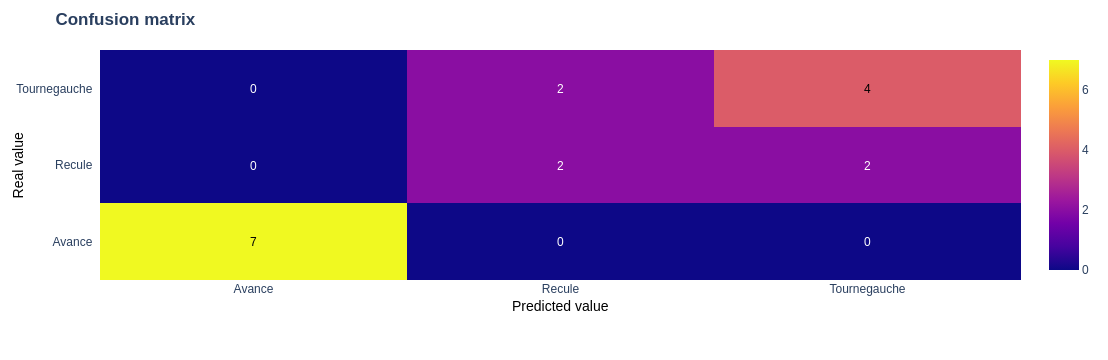

In [91]:
confusion_matrix_clf(clf_svm_gaus_3, X_test, y_test)

### 4) Results for STFT + Scale data

<div class="alert alert-block alert-info">
TO DO</div>

In [98]:
clf_svm_gaus_4 = GridSearchCV(pipe_svm_4, param_grid_svm_gaus_4, cv=loo, return_train_score=True)

In [99]:
clf_svm_gaus_4.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('stft',
                                        <__main__.STFT object at 0x7f2c0334c7f0>),
                                       ('scaler', StandardScaler()),
                                       ('SVM', SVC())]),
             param_grid={'SVM__C': [0.1, 1, 5, 10, 20, 50, 100, 200, 500, 1000,
                                    2000],
                         'SVM__gamma': ['scale', 'auto', 1],
                         'SVM__kernel': ['rbf'],
                         'stft__idx_frequence_max': [80, 90, 95],
                         'stft__stat': [<function max at 0x7f2c303bb870>,
                                        <function mean at 0x7f2c303c8c70>,
                                        <function median at 0x7f2c302ea6b0>]},
             return_train_score=True)

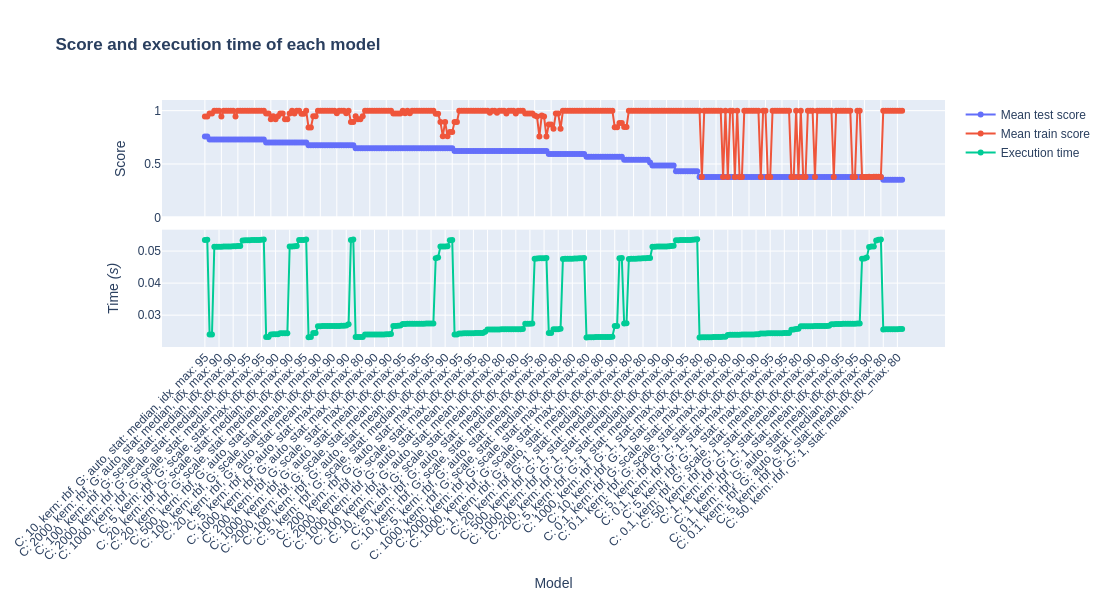

Best parameters: {'SVM__C': 10, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf', 'stft__idx_frequence_max': 95, 'stft__stat': <function median at 0x7f2c302ea6b0>}
Best score: 0.7567567567567568


In [100]:
plot_score_time_clf(clf_transform(clf_svm_gaus_4,'svm_g4'))

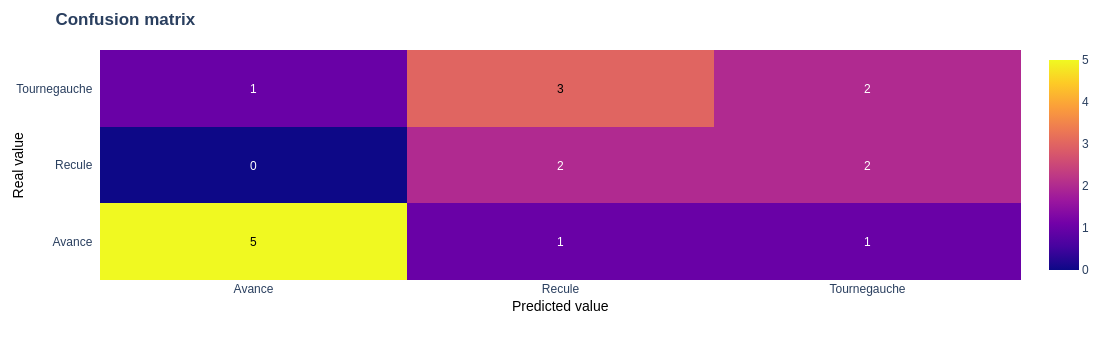

In [101]:
confusion_matrix_clf(clf_svm_gaus_4, X_test, y_test)

### 5) Summary tab

In [102]:
clf_svm_gaus_list = [clf_svm_gaus_1, clf_svm_gaus_2, clf_svm_gaus_3, clf_svm_gaus_4]
df_summary_svm_gaus = dataframe_model_summary(clf_svm_gaus_list)

In [103]:
df_summary_svm_gaus

Pipeline  Train score  SVM__C SVM__gamma SVM__kernel  \
0         fft pca SVM      0.702703      20      scale         rbf   
1  fft scaler pca SVM      0.702703      10      scale         rbf   
2            stft SVM      0.864865     100      scale         rbf   
3     stft scaler SVM      0.756757      10      scale         rbf   

   pca__n_components  stft__idx_frequence_max stft__stat  
0               15.0                      NaN        NaN  
1               17.0                      NaN        NaN  
2                NaN                     80.0     median  
3                NaN                     95.0     median

## E) Polynomial kernel

### 1) Results for FFT + PCA data

In [104]:
clf_svm_poly_1 = GridSearchCV(pipe_svm_1, param_grid_svm_poly_1, cv=loo, return_train_score=True)

In [105]:
clf_svm_poly_1.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('fft', FFT()), ('pca', PCA()),
                                       ('SVM', SVC())]),
             param_grid={'SVM__C': [1, 10, 50, 100, 500, 1000],
                         'SVM__degree': [3, 4], 'SVM__gamma': ['scale', 'auto'],
                         'SVM__kernel': ['poly'],
                         'pca__n_components': [15, 20]},
             return_train_score=True)

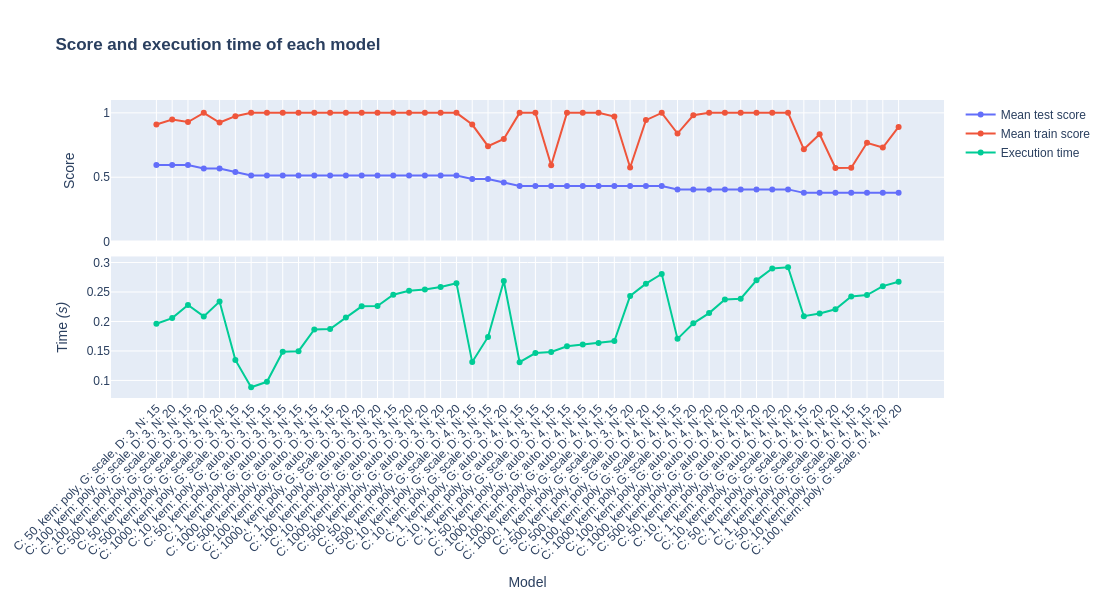

Best parameters: {'SVM__C': 50, 'SVM__degree': 3, 'SVM__gamma': 'scale', 'SVM__kernel': 'poly', 'pca__n_components': 15}
Best score: 0.5945945945945946


In [106]:
plot_score_time_clf(clf_transform(clf_svm_poly_1,'svm_p1'))

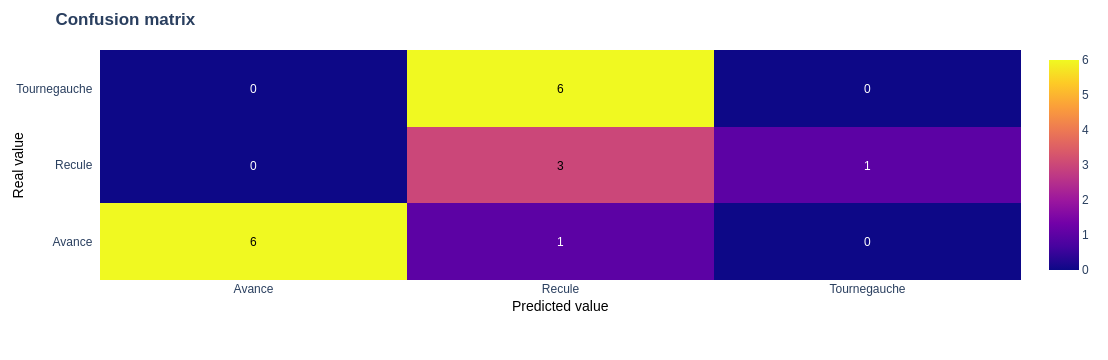

In [107]:
confusion_matrix_clf(clf_svm_poly_1, X_test, y_test)

### 2) Results for FFT + Scale + PCA data

In [108]:
clf_svm_poly_2 = GridSearchCV(pipe_svm_2, param_grid_svm_poly_2, cv=loo, return_train_score=True)

In [109]:
clf_svm_poly_2.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('fft', FFT()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()), ('SVM', SVC())]),
             param_grid={'SVM__C': [1, 10, 50, 100, 500, 1000],
                         'SVM__degree': [3, 4], 'SVM__gamma': ['scale', 'auto'],
                         'SVM__kernel': ['poly'],
                         'pca__n_components': [15, 20]},
             return_train_score=True)

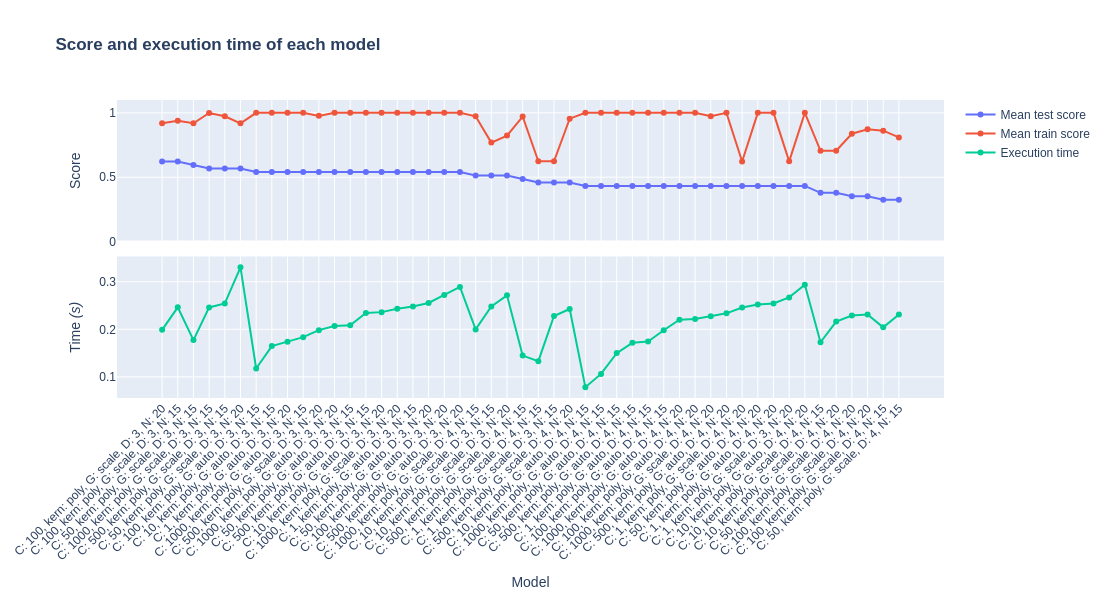

Best parameters: {'SVM__C': 100, 'SVM__degree': 3, 'SVM__gamma': 'scale', 'SVM__kernel': 'poly', 'pca__n_components': 15}
Best score: 0.6216216216216216


In [110]:
plot_score_time_clf(clf_transform(clf_svm_poly_2,'svm_p2'))

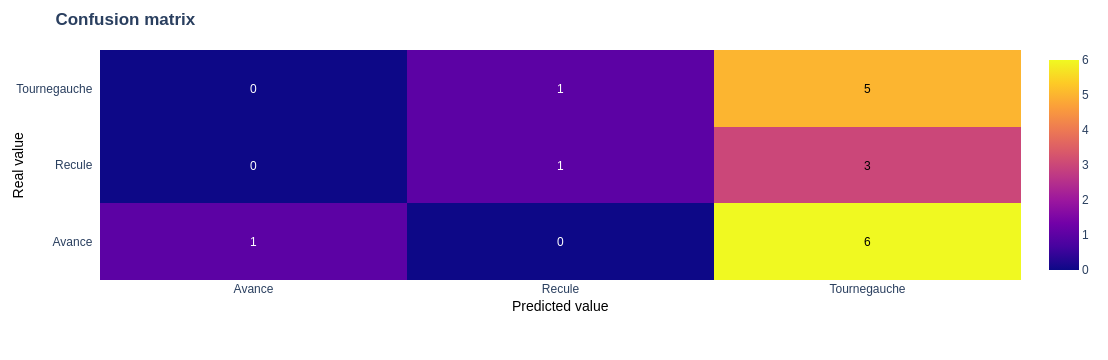

In [111]:
confusion_matrix_clf(clf_svm_poly_2, X_test, y_test)

### 3) Results for STFT data

In [112]:
clf_svm_poly_3 = GridSearchCV(pipe_svm_3, param_grid_svm_poly_3, cv=loo, return_train_score=True)

In [113]:
clf_svm_poly_3.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('stft',
                                        <__main__.STFT object at 0x7f2c0334c7f0>),
                                       ('SVM', SVC())]),
             param_grid={'SVM__C': [1, 10, 50, 100, 500, 1000],
                         'SVM__degree': [3, 4], 'SVM__gamma': ['scale', 'auto'],
                         'SVM__kernel': ['poly'],
                         'stft__idx_frequence_max': [80, 90, 95],
                         'stft__stat': [<function max at 0x7f2c303bb870>,
                                        <function mean at 0x7f2c303c8c70>,
                                        <function median at 0x7f2c302ea6b0>]},
             return_train_score=True)

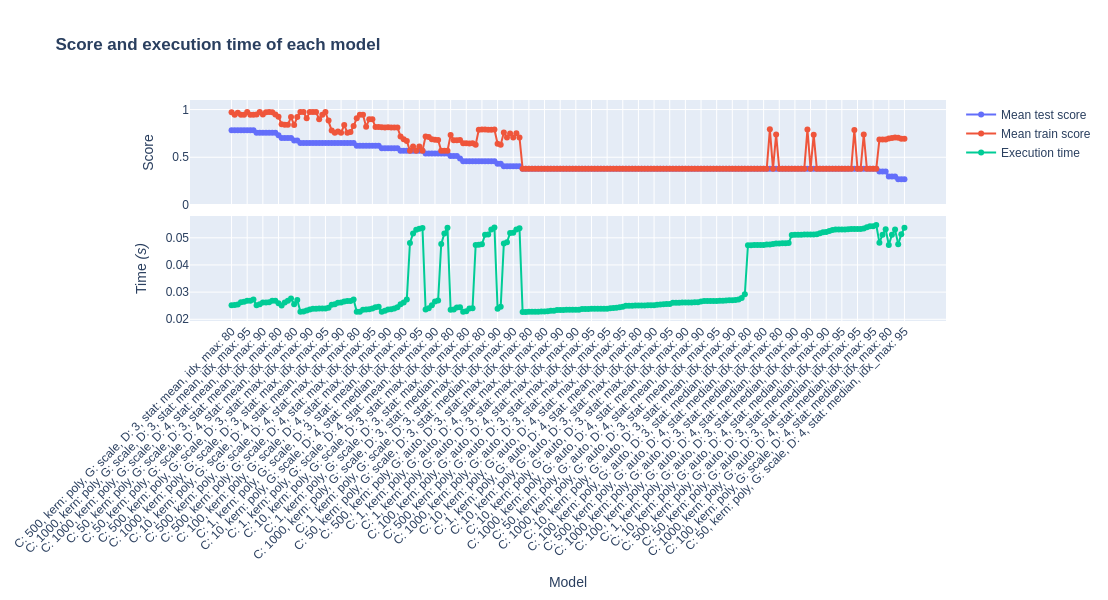

Best parameters: {'SVM__C': 100, 'SVM__degree': 3, 'SVM__gamma': 'scale', 'SVM__kernel': 'poly', 'stft__idx_frequence_max': 80, 'stft__stat': <function mean at 0x7f2c303c8c70>}
Best score: 0.7837837837837838


In [114]:
plot_score_time_clf(clf_transform(clf_svm_poly_3,'svm_p3'))

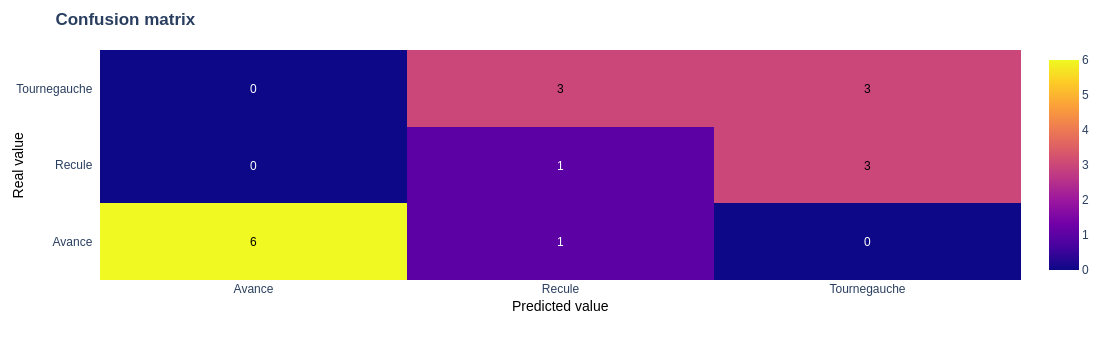

In [115]:
confusion_matrix_clf(clf_svm_poly_3, X_test, y_test)

### 4) Results for STFT + Scale data

In [116]:
clf_svm_poly_4 = GridSearchCV(pipe_svm_4, param_grid_svm_poly_4, cv=loo, return_train_score=True)

In [117]:
clf_svm_poly_4.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('stft',
                                        <__main__.STFT object at 0x7f2c0334c7f0>),
                                       ('scaler', StandardScaler()),
                                       ('SVM', SVC())]),
             param_grid={'SVM__C': [1, 10, 50, 100, 500, 1000],
                         'SVM__degree': [3, 4], 'SVM__gamma': ['scale', 'auto'],
                         'SVM__kernel': ['poly'],
                         'stft__idx_frequence_max': [80, 90, 95],
                         'stft__stat': [<function max at 0x7f2c303bb870>,
                                        <function mean at 0x7f2c303c8c70>,
                                        <function median at 0x7f2c302ea6b0>]},
             return_train_score=True)

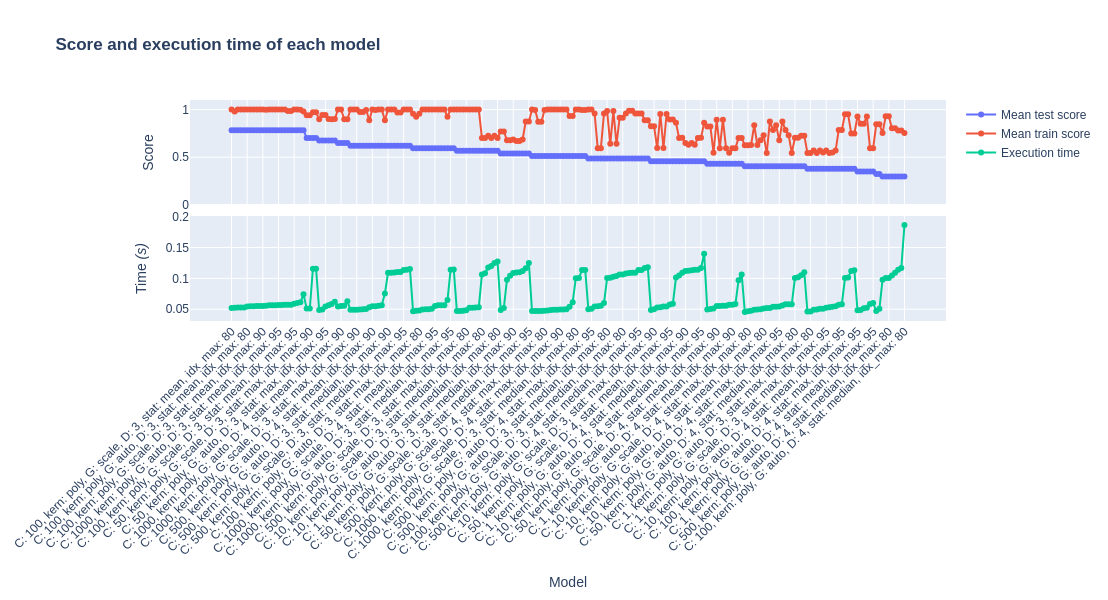

Best parameters: {'SVM__C': 50, 'SVM__degree': 3, 'SVM__gamma': 'scale', 'SVM__kernel': 'poly', 'stft__idx_frequence_max': 80, 'stft__stat': <function mean at 0x7f2c303c8c70>}
Best score: 0.7837837837837838


In [118]:
plot_score_time_clf(clf_transform(clf_svm_poly_4,'svm_p4'))

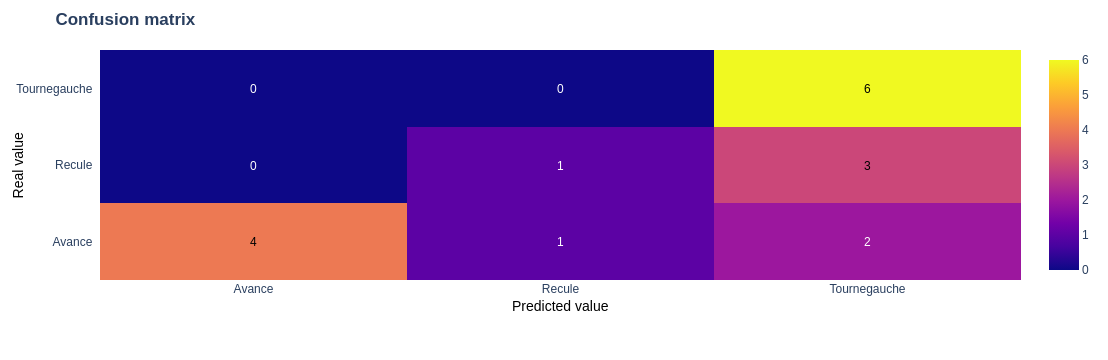

In [119]:
confusion_matrix_clf(clf_svm_poly_4, X_test, y_test)

### 5) Summary tab

In [120]:
clf_svm_poly_list = [clf_svm_poly_1, clf_svm_poly_2, clf_svm_poly_3, clf_svm_poly_4]
df_summary_svm_poly = dataframe_model_summary(clf_svm_poly_list)

In [121]:
df_summary_svm_poly

Pipeline  Train score  SVM__C  SVM__degree SVM__gamma  \
0         fft pca SVM      0.594595      50            3      scale   
1  fft scaler pca SVM      0.621622     100            3      scale   
2            stft SVM      0.783784     100            3      scale   
3     stft scaler SVM      0.783784      50            3      scale   

  SVM__kernel  pca__n_components  stft__idx_frequence_max stft__stat  
0        poly               15.0                      NaN        NaN  
1        poly               15.0                      NaN        NaN  
2        poly                NaN                     80.0       mean  
3        poly                NaN                     80.0       mean

## F) Summary

In [122]:
clf_svm_list = [clf_svm_lin_1, clf_svm_lin_2, clf_svm_lin_3, clf_svm_lin_4, clf_svm_gaus_1, clf_svm_gaus_2, clf_svm_gaus_3, clf_svm_gaus_4, clf_svm_poly_1, clf_svm_poly_2, clf_svm_poly_3, clf_svm_poly_4]
df_summary_svm = dataframe_model_summary(clf_svm_list)

NameError: name 'clf_svm_lin_2' is not defined

In [ ]:
df_summary_svm

## G) Borderies visual representation

<div class="alert alert-block alert-info">
To display the decision borders, we repeat the same process as before. But this time before applying our SVM, we carry out a dimension reduction by PCA to obtain only 2 dimensions. It is a large approximation but the objective is just to visualize the effect of the different kernel.</div>

### 1) Pipeline creation

<div class="alert alert-block alert-info">
We impose a number of components of 2. And for visualization, we decide to just use a STFT + Scale. We don't need to use every method.</div>

In [14]:
loo = LeaveOneOut() #cross validation
pca_visu = PCA(n_components=2)
scaler = StandardScaler()
stft_class = STFT()
SVM = SVC()

In [15]:
pipe_visu_coeff = Pipeline(steps=[("stft", stft_class), ("scaler", scaler), ("pca", pca_visu), ("SVM", SVM)])

### 2) Param_grid

<div class="alert alert-block alert-info">
We redo a param_grid for each kernel.</div>

In [32]:
### for linear kernel
param_grid_svm_visu_lin = {
    "stft__stat": [np.max, np.mean, np.median],
    "stft__idx_frequence_max": [75, 80, 85, 90],
    "SVM__kernel": ['linear'],
    "SVM__C": [1,10,50,100,200,500,1000,1500,2000,3000],
}

### for gaussian kernel
param_grid_svm_visu_gaus = {
    "stft__stat": [np.max, np.mean, np.median],
    "stft__idx_frequence_max": [80, 90, 95],
    "SVM__kernel": ['rbf'],
    "SVM__C": [0.1,1,5,10,20,50,100,200,500,1000,2000],
    "SVM__gamma": ['scale', 'auto', 1] ,
}

### for polynomial kernel
param_grid_svm_visu_poly = {
    "stft__stat": [np.max, np.mean, np.median],
    "stft__idx_frequence_max": [80, 90],
    "SVM__kernel": ['poly'],
    "SVM__C": [,1,5,10,50,100,200,500],
    "SVM__gamma": ['scale', 'auto', 1] ,
    # "SVM__degree": [3, 4,],
}

### 3) Plot function

<div class="alert alert-block alert-info">
The border display function.</div>

In [28]:
def visu_border_svm(estim, X, y):

    best_estim = estim.best_estimator_
    ### We are taking the first steps in our pipeline
    X_stft = best_estim.named_steps['stft'].transform(X)
    X_scale = best_estim.named_steps['scaler'].transform(X_stft)
    X_reduced = best_estim.named_steps['pca'].transform(X_scale)

    ### We save our classifier separately
    classifier = best_estim.named_steps['SVM']
    classifier.fit(X_reduced, y)

    ### We create the grid for the display
    x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
    y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    # Prédiction sur la grille de points
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)


    ### Mapping dictionnary
    class_labels = {0: 'Avance', 1: 'Recule', 2: 'Tournegauche'}

    ### We make our display in plotly
    fig = go.Figure()
    
    ### Addition of decision zones
    fig.add_trace(go.Contour(
        x=np.linspace(x_min, x_max, 100),
        y=np.linspace(y_min, y_max, 100),
        z=Z,
        # colorscale='coolwarm',
        showscale=False,
        opacity=0.8,

    ))

    ### Adding data points
    fig.add_trace(go.Scatter(
        x=X_reduced[:, 0],
        y=X_reduced[:, 1],
        mode='markers',
        marker=dict(
            color=y, 
            showscale=True,
            colorbar=dict(
                title='Class',
                tickvals=list(class_labels.keys()),
                ticktext=list(class_labels.values())
            ),
            line=dict(width=0.8, color='black')
        ),
        showlegend=False,
    ))
    
    ### Formatting the figure
    fig.update_layout(
        title="<b>Decision boundary with PCA-reduced data and " + best_estim.named_steps['SVM'].kernel + " kernel </b>",
        xaxis_title="PCA component 1",
        yaxis_title="PCA component 2",
        xaxis=dict(range=[x_min, x_max]),
        yaxis=dict(range=[y_min, y_max])
    )

    print("Best parameters:", estim.best_params_)
    print("Best score:", estim.best_score_)

    return fig

### 4) Find best estimator

<div class="alert alert-block alert-info">
We find the best estimator for each kernel.</div>

In [18]:
clf_visu_lin = GridSearchCV(pipe_visu_coeff, param_grid_svm_visu_lin, cv=loo, return_train_score=True)
clf_visu_gaus = GridSearchCV(pipe_visu_coeff, param_grid_svm_visu_gaus, cv=loo, return_train_score=True)
clf_visu_poly = GridSearchCV(pipe_visu_coeff, param_grid_svm_visu_poly, cv=loo, return_train_score=True)

In [177]:
clf_visu_lin.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('stft',
                                        <__main__.STFT object at 0x7f0a2b5e1030>),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('SVM', SVC())]),
             param_grid={'SVM__C': [1, 10, 50, 100, 200, 500, 1000, 1500, 2000,
                                    3000],
                         'SVM__kernel': ['linear'],
                         'stft__idx_frequence_max': [75, 80, 85, 90],
                         'stft__stat': [<function max at 0x7f0ad856a2b0>,
                                        <function mean at 0x7f0ad856b670>,
                                        <function median at 0x7f0ad8004930>]},
             return_train_score=True)

In [19]:
clf_visu_gaus.fit(X_train, y_train)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('stft',
                                        <__main__.STFT object at 0x7f2c0cd6db40>),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('SVM', SVC())]),
             param_grid={'SVM__C': [0.1, 1, 5, 10, 20, 50, 100, 200, 500, 1000,
                                    2000],
                         'SVM__gamma': ['scale', 'auto', 1],
                         'SVM__kernel': ['rbf'],
                         'stft__idx_frequence_max': [80, 90, 95],
                         'stft__stat': [<function max at 0x7f2c303bb870>,
                                        <function mean at 0x7f2c303c8c70>,
                                        <function median at 0x7f2c302ea6b0>]},
             return_train_score=True)

In [33]:
clf_visu_poly.fit(X_train, y_train)

KeyboardInterrupt: 

### 5) Results

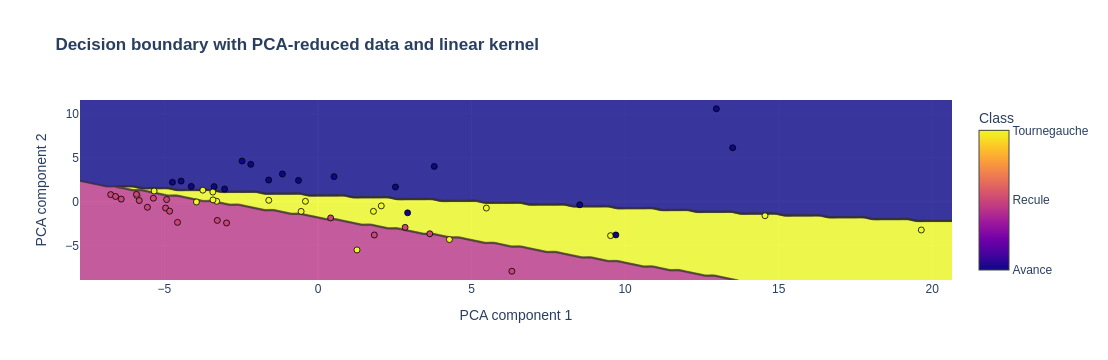

In [276]:
# visu_border_svm(clf_visu_lin, X, y)

Best parameters: {'SVM__C': 5, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf', 'stft__idx_frequence_max': 95, 'stft__stat': <function median at 0x7f2c302ea6b0>}
Best score: 0.7837837837837838


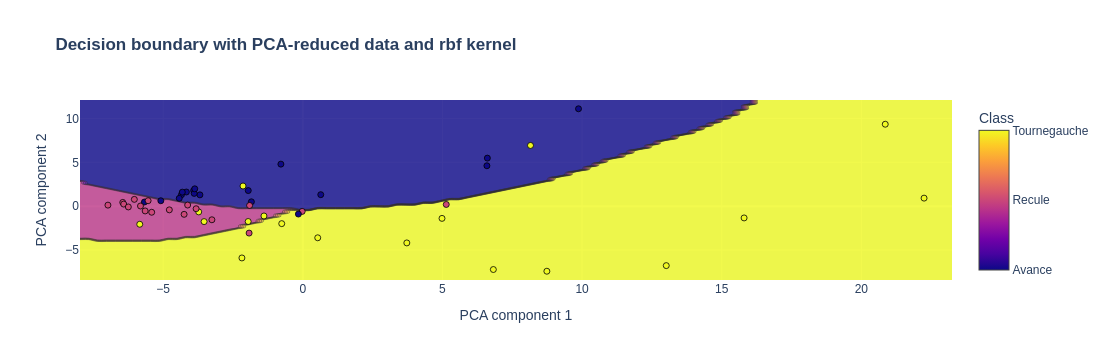

In [29]:
visu_border_svm(clf_visu_gaus, X, y)

In [ ]:
visu_border_svm(clf_visu_poly, X, y)

# Part III: Ensemble Method

## 1. Bootstrap Aggregation : Bagging

Boostrap consists in creating multiple data sets as follows. Suppose our
original data set consists of $N$ data points $X = \{x_1,..., x_N \}$. We can create a new
data set $X_B$ by drawing $N$ points at random from X, with replacement, so that some
points in $X$ may be replicated in $X_B$, whereas other points in $X$ may be absent from
$X_B$. This process can be repeated $L$ times to generate $L$ data sets each of size $N$ and
each obtained by sampling from the original data set $X$.

Consider a binary classification problem in which we are trying to predict the class, and suppose we generate $M$ bootstrap data sets and then use each to train a separate copy $y_m(x)$ of a classifier where $m = 1,...,M$. The committee prediction is given by voting with all $M$ models.

1. First you will transform $y$ in $y^1$ as follow
if $y = 1$, then $y^1 = 1$
if $y = 0$ or $y = 2$, then $y^1 = 0$
Now we can apply binary classification

2. Code from scratch the Bagging of Decision trees with *max_depth = 2* only and compare the accuracy of the bagging model with the mean accuracy of the models and conclude. (the bootstrap is done on the training set with np.random.choice, and use $M=100$)

3. Apply Random Forest on the initial classification problem (3 classes) and adjust the hyperparameters. Is random Forest a Bagging model?



In [93]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [94]:
y1 = []
for i in range(len(y)):
    if y[i] == 1:
        y1.append(1)
    else:
        y1.append(0)

In [98]:
class Bagging:
    def __init__(self, num_clfs):
        self.BaseClassifierClass = DecisionTreeClassifier(max_depth = 2)
        self.num_clfs = num_clfs
        self.clfs = [self.DecisionTreeClassifier(max_depth = 2) for _ in range(self.num_clfs)]

    def fit(self, X, y):
        N = len(X)
        for m in range(self.num_clfs):
            sample_ind = np.random.randint(0, N, N)
            X_resampled = X[sample_ind] 
            y_resampled = y[sample_ind]
            self.clfs[m].fit(X_resampled, y_resampled)
            
    def predict(self, X):
        base_pred = np.zeros((self.num_clfs, len(X)))
        for m in range(self.num_clfs):
            base_pred[m] = self.clfs[m].predict(X)
        return np.sign(np.sum(base_pred, axis = 0 ) )

In [95]:
### 2. 
X_train, X_test, y_train, y_test = train_test_split(X,y1,test_size=0.4, random_state=42)
np.random.seed(seed=42)

## 2. Adaptative boosting : AdaBoost

Here is the algorithm Adaboost

1. Initialize the data weighting coefficients ${w_n}$ by setting $w_n^{(1)} = 1/N$ for $n = 1,...,N$.
2. For $m = 1,...,M$:
    
    **(a)** Fit a classifier $y_m(x)$ to the training data by minimizing the weighted
error function
    
    $J_m = \sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}$

    where $I(y_m(x)\neq t_n)$ is the indicator function and equals $1$ when $y_m(x_n) 	= t_n$ and $0$ otherwise

    **(b)** Evaluate the quantities

    $\epsilon_m = \frac{\sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}}{\sum_{n=1}^N{w_n^{(m)}}}$

    and then use these to evaluate

    $\alpha_m = \textit{ln}\left({\frac{1-\epsilon_m}{\epsilon_m}}\right)$

    **(c)** Update the data weighting coefficients
    
    $w_n^{(m+1)} = w_n^{(m)} \textit{exp}\left({\alpha_m I(y_m(x_n) \neq t_n)}\right)$

3. Make predictions using the final model, which is given by

    $Y_M(x) = \text{sign}\left(\sum_{m=1}^M {\alpha_m y_m(x)}\right)$


**Question 1 :** Code from scratch the Adaboost algorithm in the same configuration as Bagging in the previous section. Use the sklearn decision tree classifier and its argument *sample_weight*. Compare its performances with Bagging.


**Question 2 :** 
With sklearn library, apply adaboost with decision tree (*max_depth=2*) on the 3-class classification problem. Find good parameters with the leave one out cross validation. Do the same thing with Gradient bossting.
If you have the time, you can test with XGBoost.


# Partie IV : Neural Network with pytorch

Below we create torch tensor with the shape $(N,B,F)$, where
    
$N$ is the number of recordings in the set (train/test)

$B$ the size of batch, we choose $B=1$ because the dataset is really small

$F$ is the number of features

The tensors are converted to float type

The train set and test set constitute 50% of the initial dataset

**Transform X with your preprocessing**

In [ ]:
import torch
### transform X with your preprocessing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=42)
X_train = torch.tensor(X_train).reshape((X_train.shape[0],1,-1)).float()
X_test = torch.tensor(X_test).reshape((X_test.shape[0],1,-1)).float()
y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=- 1).reshape((X_train.shape[0],1,-1)).float()
y_test = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=- 1).reshape((X_test.shape[0],1,-1)).float()

**Question 1:** : Create a model class (descending from torch.nn.Module). In a first time choose the appropriate architecture and the appropriate loss (the loss appear later) to reproduce logistic regression

Usually a FNN is a succession of blocks (linear -> ReLU). Finally the networks transforms the initial vector into the output $\hat{y} \in \mathbb{R}^3, \hat{y}=(\mathbb{P}(y=0|x),\mathbb{P}(y=1|x),\mathbb{P}(y=2|x))$ where $y$ is the word we want to predict and $x \in \mathbb{R}^{18522}$ is the accoustic signal

    
    

In [116]:
class NNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            
            ### Define here the succession of torch.nn modules that will constitutes your network
            ### building blocks are torch.nn.ReLU, torch.nn.Linear

        )
    
    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return self.network(xb)

In [117]:
model = NNClassification()
num_epochs = 10

result_test_loss = []
result_train_loss=[]

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr)
loss = ### What loss do you think is well suited for the classification problem (same as logistic regression)

for epoch in range(num_epochs):

    model.train()
    train_losses = []
    for i in range(X_train.shape[0]):
       ### code the training step (compute loss -> optimization step -> save the loss )
        
    model.eval()
    test_losses = []
    for i in range(X_test.shape[0]):
        ### code the eval step  (compute loss -> save the loss )

    result_train_loss.append(torch.stack(train_losses).mean().item())
    result_test_loss.append( torch.stack(test_losses).mean().item())
    



**Question 2:** Plot the train and test loss. What do you observe?

**Question 3 :** Compute the accuracy.

**Question 4:** If you encounter overfitting try to regularize your model with Dropout and/or L2/L1 Regularization

**Question 5(Bonus)** : Create a CNN that takes in input the accoustic signal without preprocessing